<a href="https://colab.research.google.com/github/vglykos/space-titanic-kaggle/blob/main/space_titanic_080336.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Library & dataset Import

In [397]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Machine learning models and utilities
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.impute import KNNImputer
import xgboost as xgb


# Set plot style
sns.set_theme()
sns.set(font_scale=1.2)
plt.style.use('seaborn-whitegrid')
#palette = ['slateblue', 'sandybrown']
palette=None

#my_color = (0.1, 0.2, 0.5, 0.3)
#palette=[my_color]

In [398]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [399]:
sample = pd.read_csv('/content/drive/My Drive/Colab Notebooks/space_titanic_kaggle/sample_submission.csv')
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/space_titanic_kaggle/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/space_titanic_kaggle/test.csv')
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [400]:
# Print df_train shape
print("Train dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Train dataset shape: (8693, 14)
Test dataset shape: (4277, 13)


In [401]:
df= train.copy()

In [402]:
# Percentages of missing values
missing = round(100 * df.isnull().sum() / df.shape[0], 2)

missing_df = pd.DataFrame({'% of missing values':missing})

missing_df

,% of missing values
PassengerId,0.00
HomePlanet,2.31
CryoSleep,2.50
Cabin,2.29
Destination,2.09
Age,2.06
VIP,2.34
RoomService,2.08
FoodCourt,2.11
ShoppingMall,2.39


#Exploratory Data Analysis

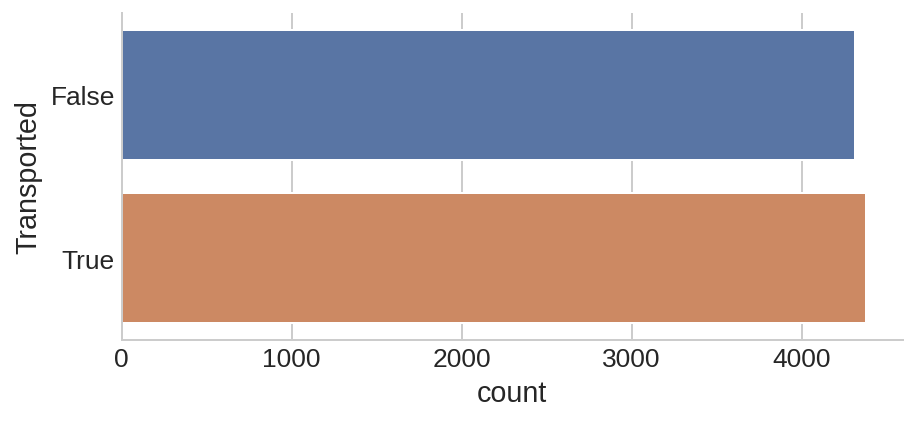

The overall percentage of transported passengers is: 50.4%


In [403]:
#Overall Transported Passengers

# Show Transported
fig, ax1 = plt.subplots(figsize=(7, 3))
sns.countplot(data=df, y='Transported', ax = ax1, orient='h', palette=palette)

sns.despine()
plt.show()

transported_perc = 100 * ((df['Transported'] == True).sum()) / ((df['Transported'] == True).count())

print('The overall percentage of transported passengers is: {:.1f}%'.format(transported_perc))

In [404]:
# About one out of two passengers was transported. This means that the training 
# dataset is well balanced: we won't have to face imbalanced classes issues.

##Features

In [405]:
#function

# Utility function
def plot_categorical_feature (feature, data=df):
    
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    fig.subplots_adjust(hspace=0.3)
   
    values = list(pd.Series(data[feature].unique()).sort_values()) 

    if np.nan in values:
        values.remove(np.nan)
    
    # Build Seaborn Barplot
    sns.barplot(data=data, x=feature, y='Transported', order=values, ax=axs[0], palette=palette)
    sns.despine() 
    axs[0].set_xlabel('')
    if feature == 'Destination': axs[0].xtick_params(axis='x', labelrotation=10)
    axs[0].set_title(feature)
    
    # Build Pieplot
    sizes = []
    for value in values:
        sizes.append(data.loc[data[feature]==value, feature].size)

    explode = []
    for size in sizes:
        if size == max(sizes):
            explode.append(0.06)
        else:
            explode.append(0)
    
    w, _, autotexts = axs[1].pie(sizes, explode=explode, shadow=True, autopct='%1.0f%%', colors=palette)

###HomePlanet

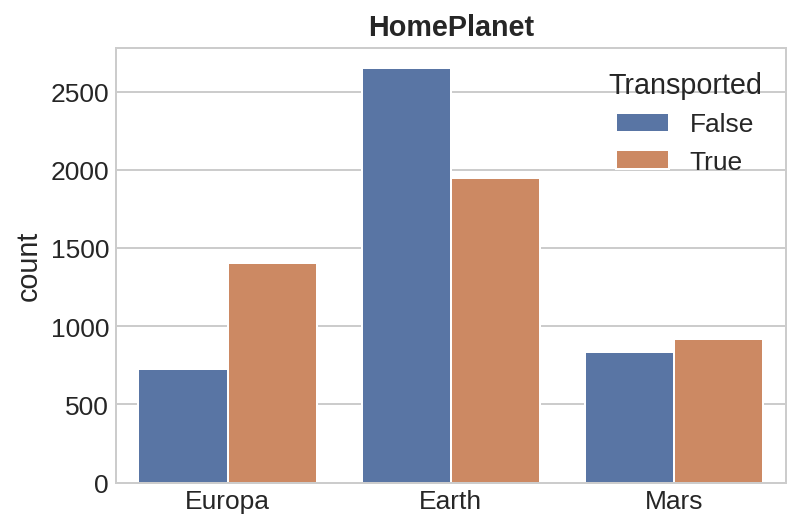

In [406]:
#HomePlanet
sns.countplot(data=df, x='HomePlanet', hue='Transported')
plt.title('HomePlanet', fontweight='bold')
plt.xlabel('')
plt.show()

#Conclusion: More passengers embarked from Earth but the transportation rates were higher for Europa and Mars

###CryoSleep

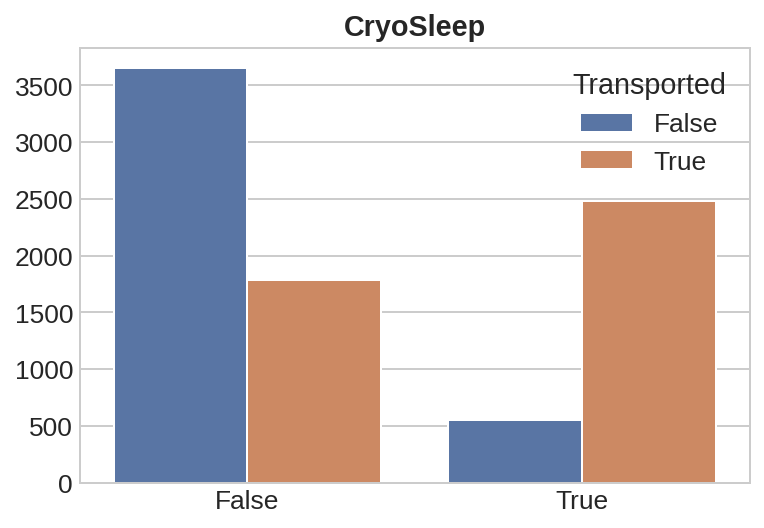

In [407]:
sns.countplot(data=df, x='CryoSleep', hue='Transported')
plt.title('CryoSleep', fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.show()
#Passengers in CryoSleep were transported in higher rates

###Destination

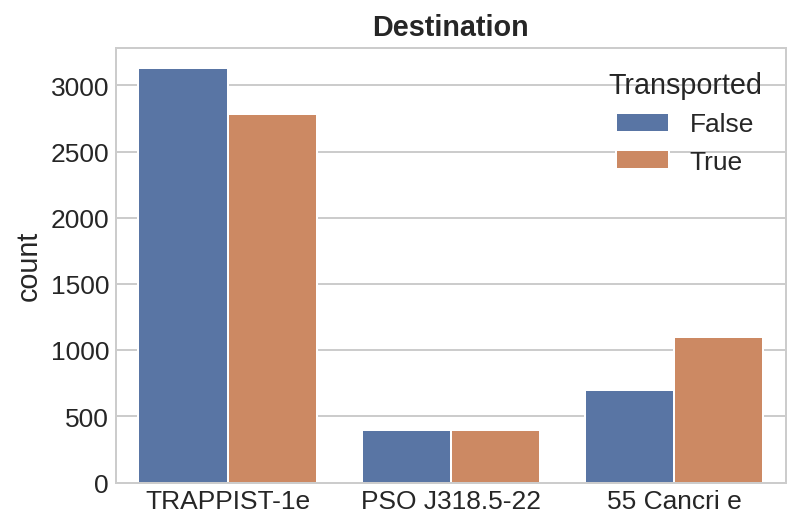

In [408]:
sns.countplot(data=df, x='Destination', hue='Transported')
plt.title('Destination', fontweight='bold')
plt.xlabel('')
plt.show()
#There is no clear indication that this feature is strongly predictive

In [409]:
df.Destination.unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan], dtype=object)

###VIP

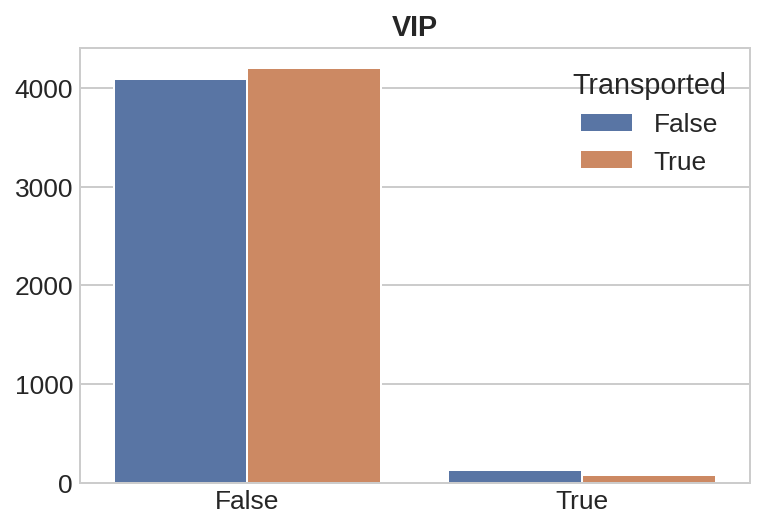

In [410]:
sns.countplot(data=df, x='VIP', hue='Transported')
plt.title('VIP', fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.show()
#I don't think this feature is predictive at all

###Age

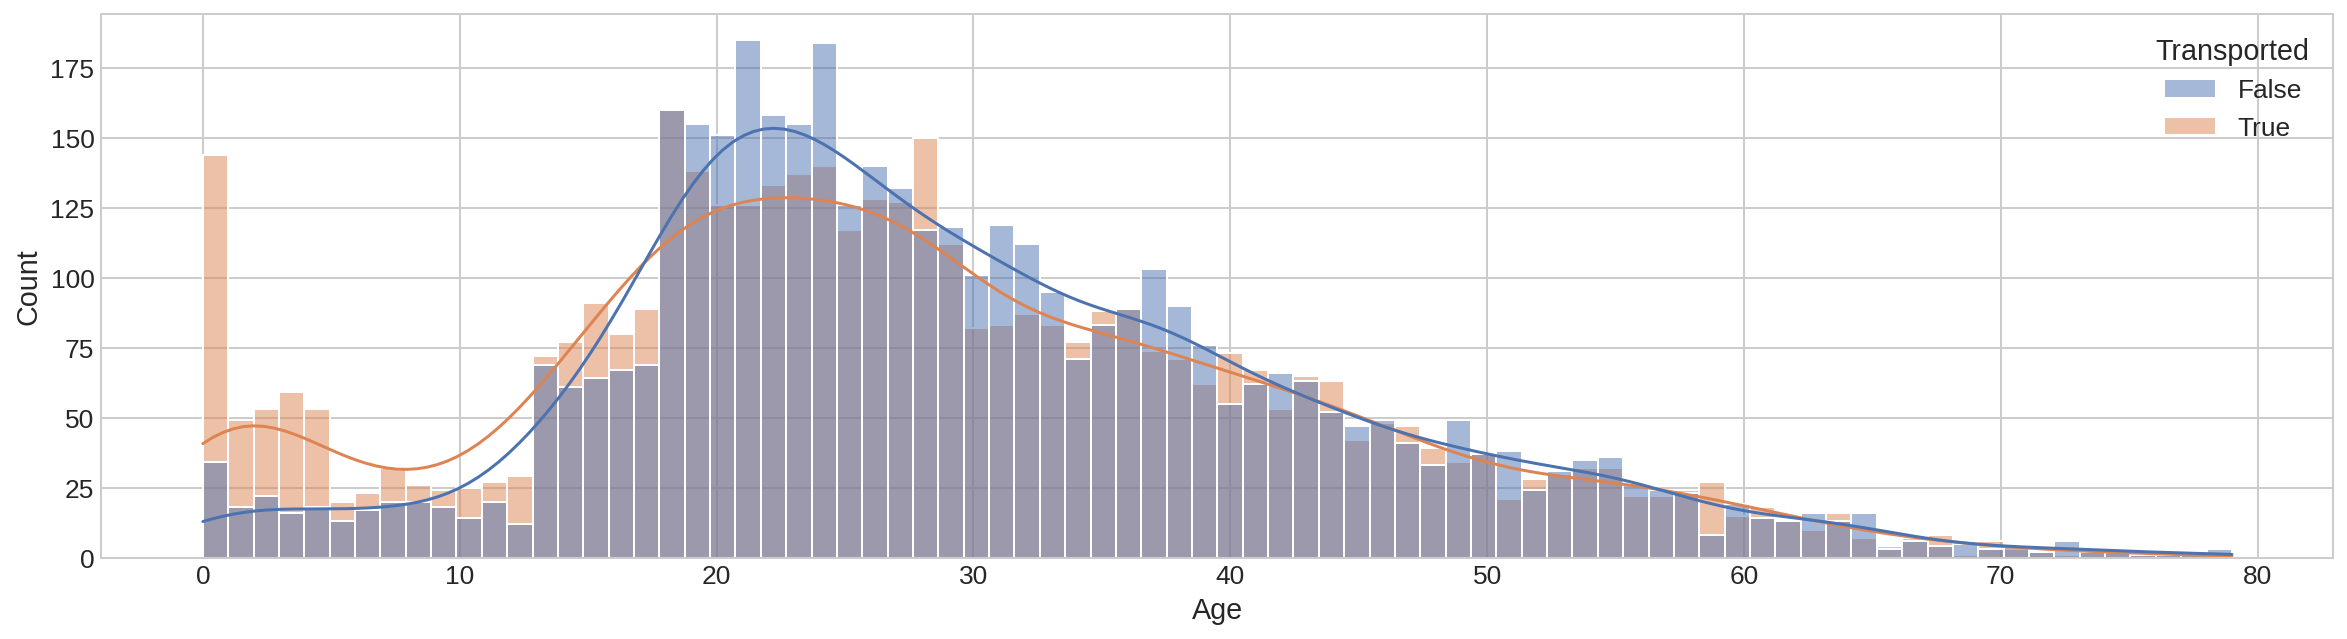

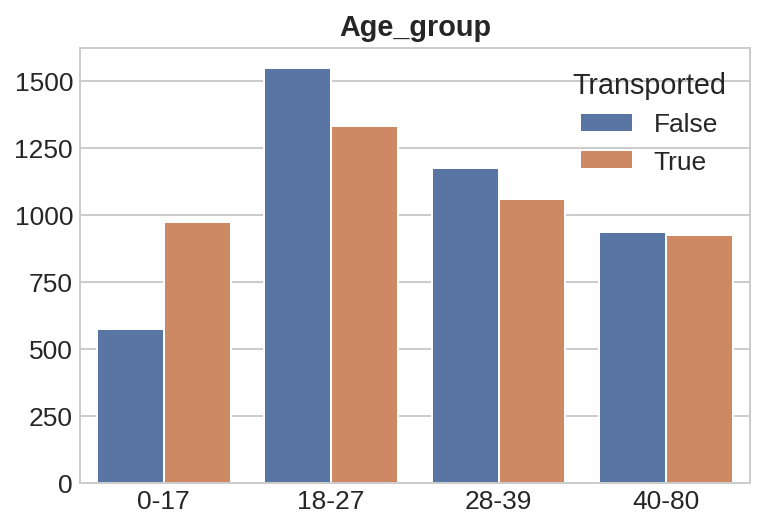

In [411]:
fig, ax = plt.subplots(figsize=(20,5))

sns.histplot(data=df, x='Age', hue='Transported', bins=80,kde=True, palette=palette, ax=ax)
# plt.xlim([0,39])
plt.show()

# sns.displot(data=df, x='Age', col="CryoSleep", hue='Transported', bins=80,kde=True, palette=palette)
# sns.despine
# plt.show()

#Very interesting. 
#Between 0-17yrs passengers have higher chances to be transported.
#Between 18-27yrs lower chances of being transported
#Between 29-39yrs transportation chances are low but not so much compared to 18-27yrs
#Between 40-80 chances are equal.
#Therefore, I will break age down to these groups ("Age_group")

# df["Age_cat"]=0
df.loc[df["Age"] <= 17 , "Age_group"] = "0-17"
df.loc[(df["Age"] > 17) & (df["Age"] <= 27) , "Age_group"] = "18-27"
df.loc[(df["Age"] > 27) & (df["Age"] <= 39) , "Age_group"] = "28-39"
df.loc[(df["Age"] > 39) & (df["Age"] <= df["Age"].max()) , "Age_group"] = "40-80"

sns.countplot(data=df, x='Age_group', hue='Transported', order = ['0-17', '18-27', '28-39', '40-80'] )
plt.title('Age_group', fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.show()

###Expenses

In [412]:
df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].describe().T

,count,mean,std,min,25%,50%,75%,max
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


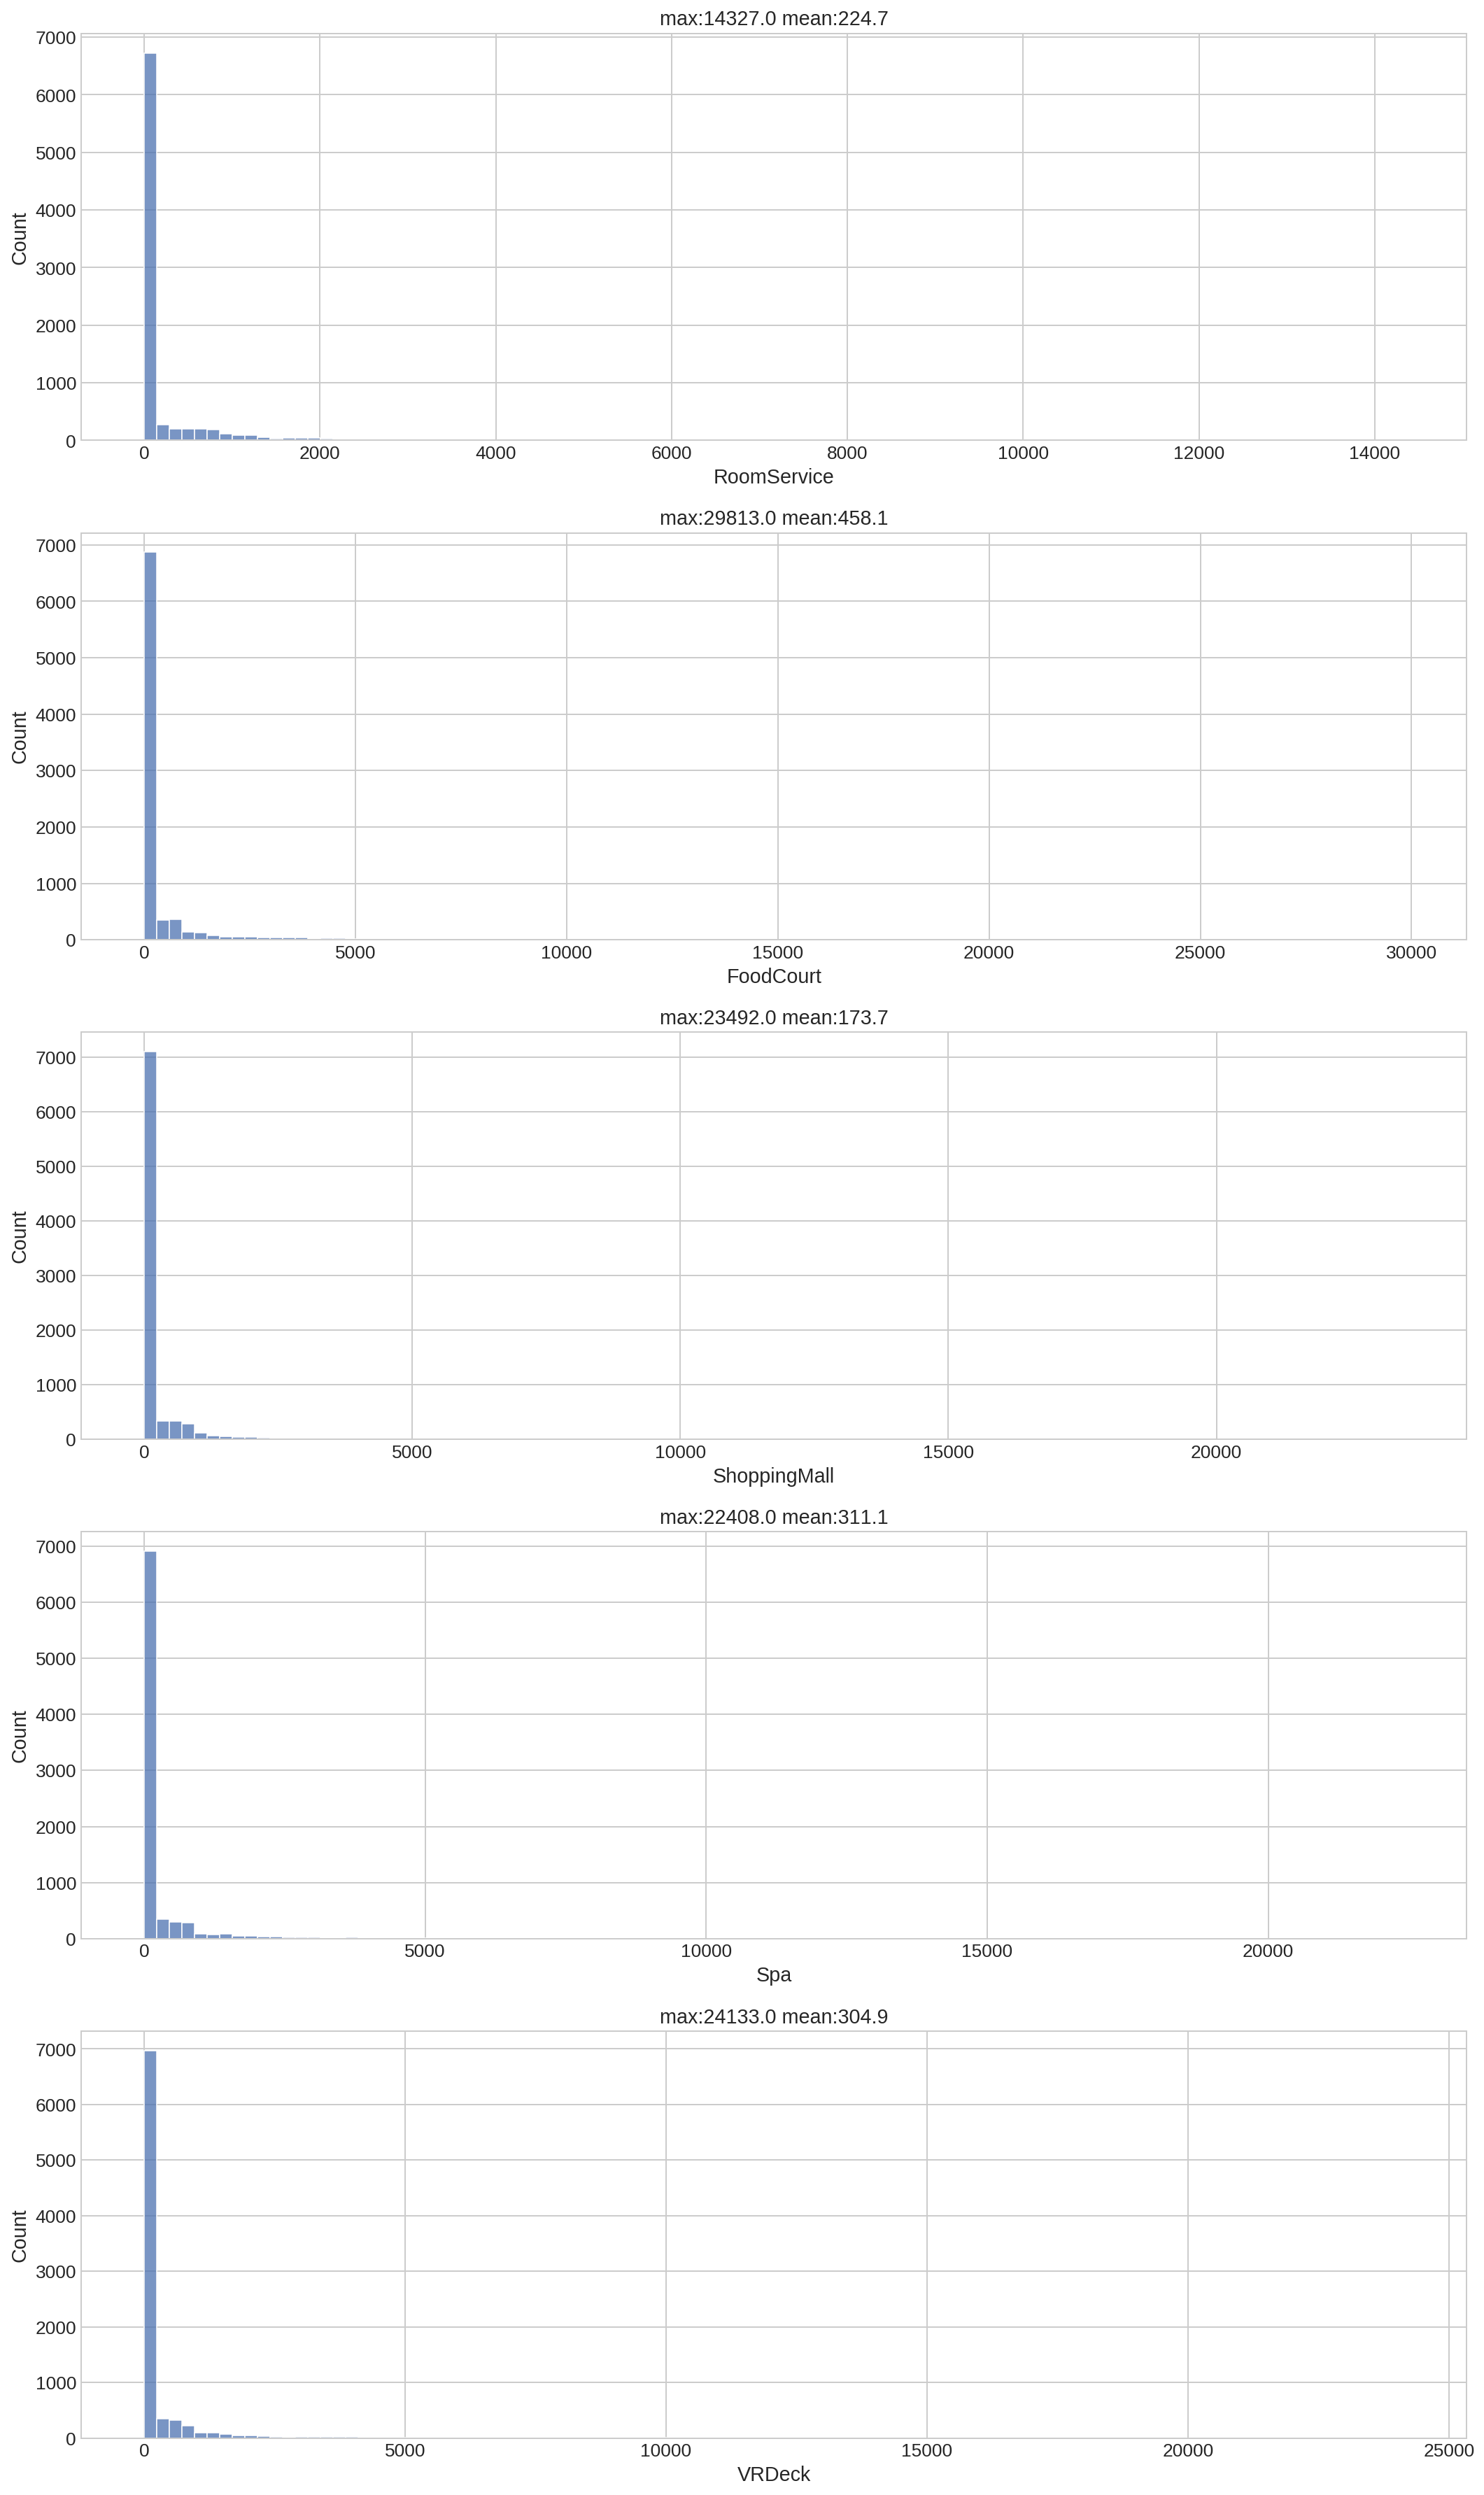

In [413]:
fig,ax = plt.subplots(5,1, figsize=(15,25))
ax = ax.ravel()

# RoomService
sns.histplot(data=df, x="RoomService", bins=100,ax=ax[0])
ax[0].set_title("max:{} mean:{:.1f}" .format(df.RoomService.max() , df.RoomService.mean()))

# FoodCourt
sns.histplot(data=df, x="FoodCourt", bins=100,ax=ax[1])
ax[1].set_title("max:{} mean:{:.1f}" .format(df.FoodCourt.max() , df.FoodCourt.mean()))

# ShoppingMall
sns.histplot(data=df, x="ShoppingMall", bins=100,ax=ax[2])
ax[2].set_title("max:{} mean:{:.1f}" .format(df.ShoppingMall.max() , df.ShoppingMall.mean()))

# Spa
sns.histplot(data=df, x="Spa", bins=100,ax=ax[3])
ax[3].set_title("max:{} mean:{:.1f}" .format(df.Spa.max() , df.Spa.mean()))

# VRDeck
sns.histplot(data=df, x="VRDeck", bins=100,ax=ax[4])
ax[4].set_title("max:{} mean:{:.1f}" .format(df.VRDeck.max() , df.VRDeck.mean()))

fig.tight_layout()
plt.show()

#These data are very skewed. I will plot them again but this time with xlim and ylim

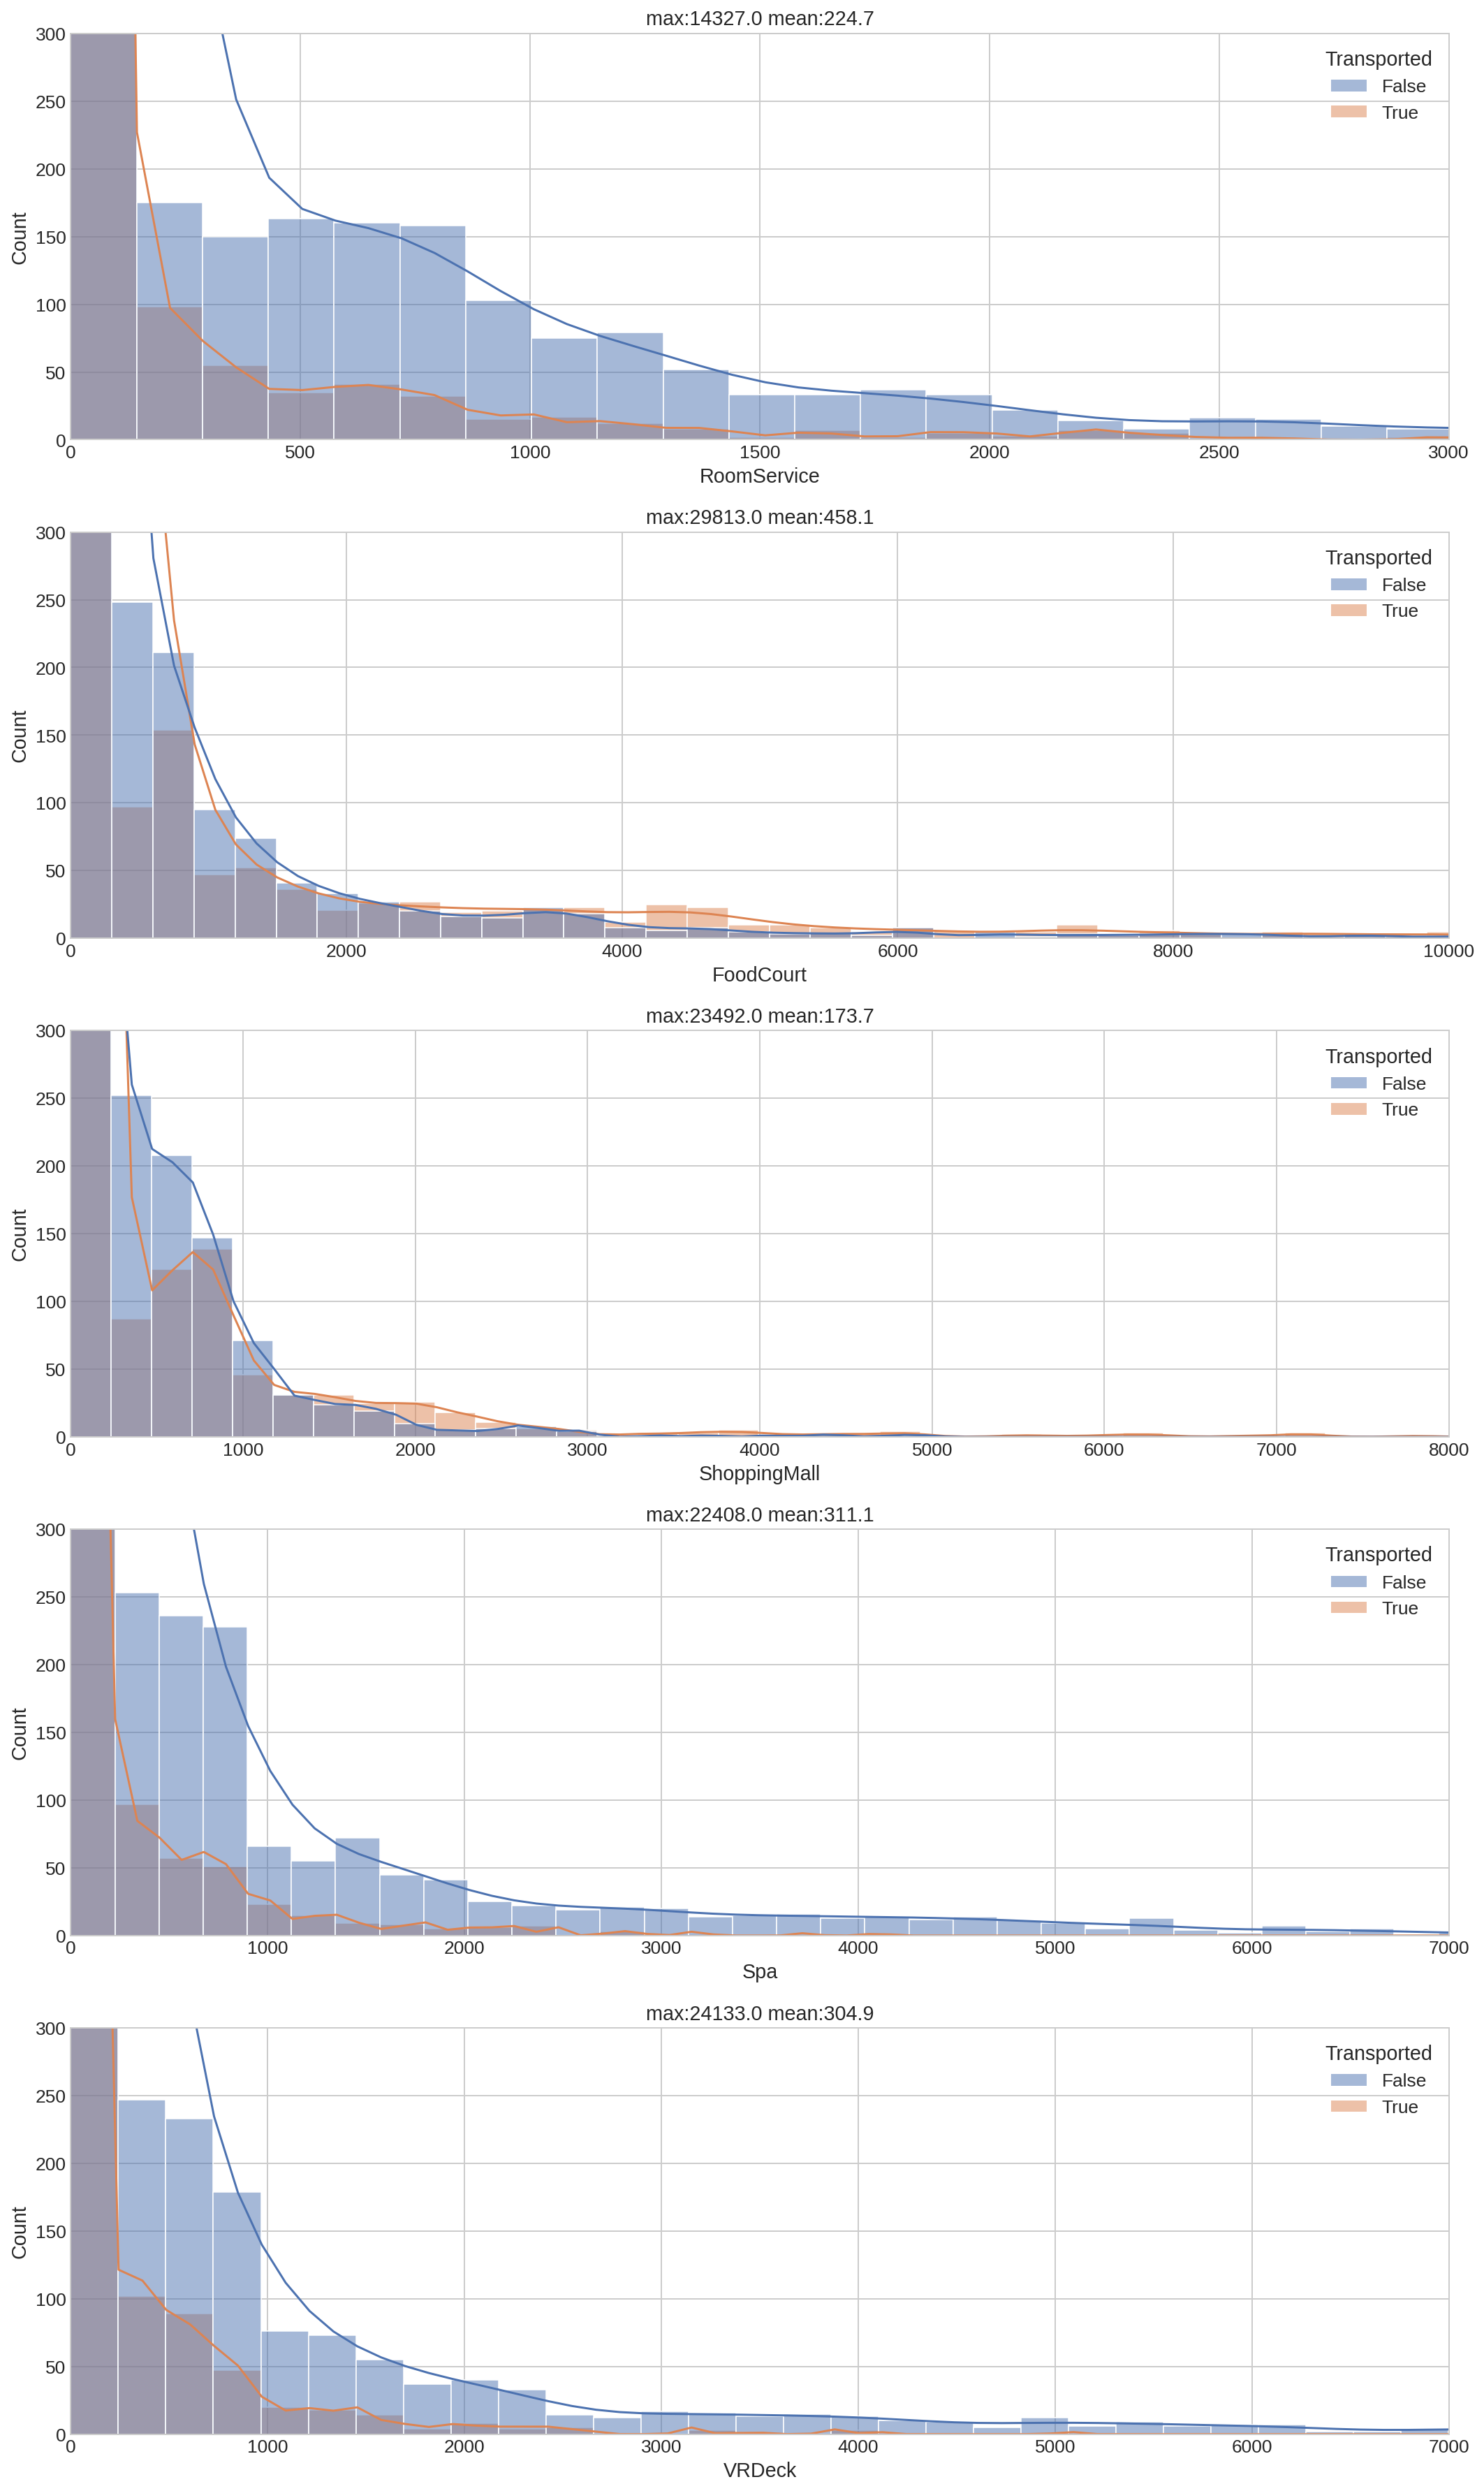

In [414]:
fig,ax = plt.subplots(5,1, figsize=(15,25))
ax = ax.ravel()

# RoomService
sns.histplot(data=df, x="RoomService", hue="Transported", bins=100, kde=True, ax=ax[0])
ax[0].set_title("max:{} mean:{:.1f}" .format(df.RoomService.max() , df.RoomService.mean()))
ax[0].set_xlim([0, 3000])
ax[0].set_ylim([0, 300])

# FoodCourt
sns.histplot(data=df, x="FoodCourt", hue="Transported", bins=100, kde=True, ax=ax[1])
ax[1].set_title("max:{} mean:{:.1f}" .format(df.FoodCourt.max() , df.FoodCourt.mean()))
ax[1].set_xlim([0, 10000])
# ax[1].set_xlim([2000, 4000])
ax[1].set_ylim([0, 300])

# ShoppingMall
sns.histplot(data=df, x="ShoppingMall", hue="Transported", bins=100, kde=True, ax=ax[2])
ax[2].set_title("max:{} mean:{:.1f}" .format(df.ShoppingMall.max() , df.ShoppingMall.mean()))
ax[2].set_xlim([0, 8000])
# ax[2].set_xlim([1000, 8000])
ax[2].set_ylim([0, 300])

# Spa
sns.histplot(data=df, x="Spa", hue="Transported", bins=100, kde=True, ax=ax[3])
ax[3].set_title("max:{} mean:{:.1f}" .format(df.Spa.max() , df.Spa.mean()))
ax[3].set_xlim([0, 7000])
ax[3].set_ylim([0, 300])

# VRDeck
sns.histplot(data=df, x="VRDeck", hue="Transported", bins=100, kde=True, ax=ax[4])
ax[4].set_title("max:{} mean:{:.1f}" .format(df.VRDeck.max() , df.VRDeck.mean()))
ax[4].set_xlim([0, 7000])
ax[4].set_ylim([0, 300])

fig.tight_layout()
plt.show()

#For RoomService, Spa and VRDeck the chances of transportation are small
#For Foodcourt and ShoppigMall the more yo spend the more chances of transportation you have.

In [415]:
#There are many passengers who don't spend money at all. I guess they are in cryo sleep
#I will calculate the sum of all expenses and study the transportation rates

df['Expenditure']=df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)

df["Expenses"]= 0
df.loc[df["Expenditure"] > 0, "Expenses"] = 1

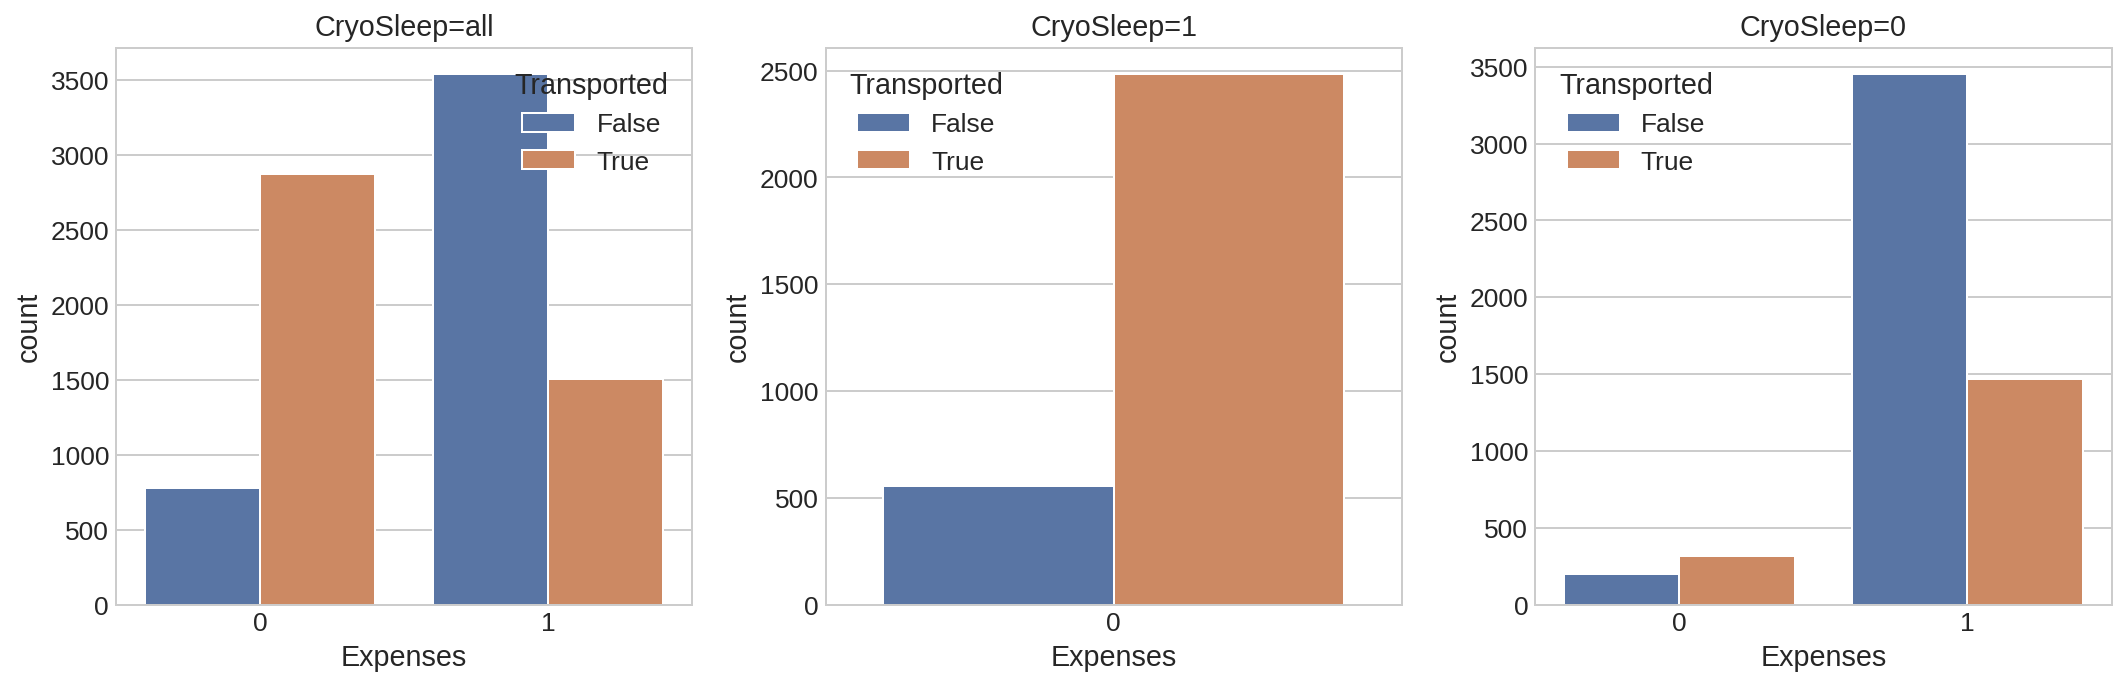

In [416]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

sns.countplot(data=df, x='Expenses', hue='Transported', ax=ax[0])
ax[0].set_title("CryoSleep=all")

sns.countplot(data=df.loc[df["CryoSleep"]==1], x='Expenses', hue='Transported', ax=ax[1])
ax[1].set_title("CryoSleep=1")

sns.countplot(data=df.loc[df["CryoSleep"]==0], x='Expenses', hue='Transported', ax=ax[2])
ax[2].set_title("CryoSleep=0")

fig.tight_layout()
plt.show()

#obviously in CryoSleep passengers don't spend money
#However, there is a small group of people who are not in cryosleep but do not spend any money at all. 
#This is wierd. Lets find out.


In [417]:
df.loc[(df["CryoSleep"]==0) & (df["Expenses"]==0)].head(10)
#After inspecting the dataset i discovered that the majority of the passengers who are not in cryosleep and did not spend a penny belong to the group 0-17.
#(It was a good choice I grouped the Age feature first)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Age_group,Expenditure,Expenses
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,28-39,0.0,0
19,0017_01,Earth,False,G/0/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Lyde Brighttt,True,0-17,0.0,0
24,0020_04,Earth,False,E/0/S,TRAPPIST-1e,10.0,False,0.0,0.0,0.0,0.0,0.0,Breney Jacostanley,True,0-17,0.0,0
26,0020_06,Earth,False,E/0/S,TRAPPIST-1e,7.0,False,0.0,0.0,0.0,0.0,0.0,Terta Mcfaddennon,False,0-17,0.0,0
34,0031_02,Mars,False,F/9/P,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,0.0,0.0,Cinets Datie,True,0-17,0.0,0
52,0056_01,Europa,False,A/1/S,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,0.0,0.0,Okulas Tractive,True,0-17,0.0,0
77,0082_03,Mars,False,F/16/P,TRAPPIST-1e,8.0,False,0.0,0.0,0.0,0.0,0.0,NaN,True,0-17,0.0,0
102,0108_03,Earth,False,G/19/S,TRAPPIST-1e,0.0,NaN,0.0,0.0,0.0,0.0,0.0,Oline Handertiz,True,0-17,0.0,0
134,0146_01,Earth,False,G/25/S,TRAPPIST-1e,56.0,False,0.0,0.0,0.0,0.0,0.0,Verly Wolferguson,False,40-80,0.0,0
157,0179_02,Earth,False,G/26/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Raque Webstephrey,False,0-17,0.0,0


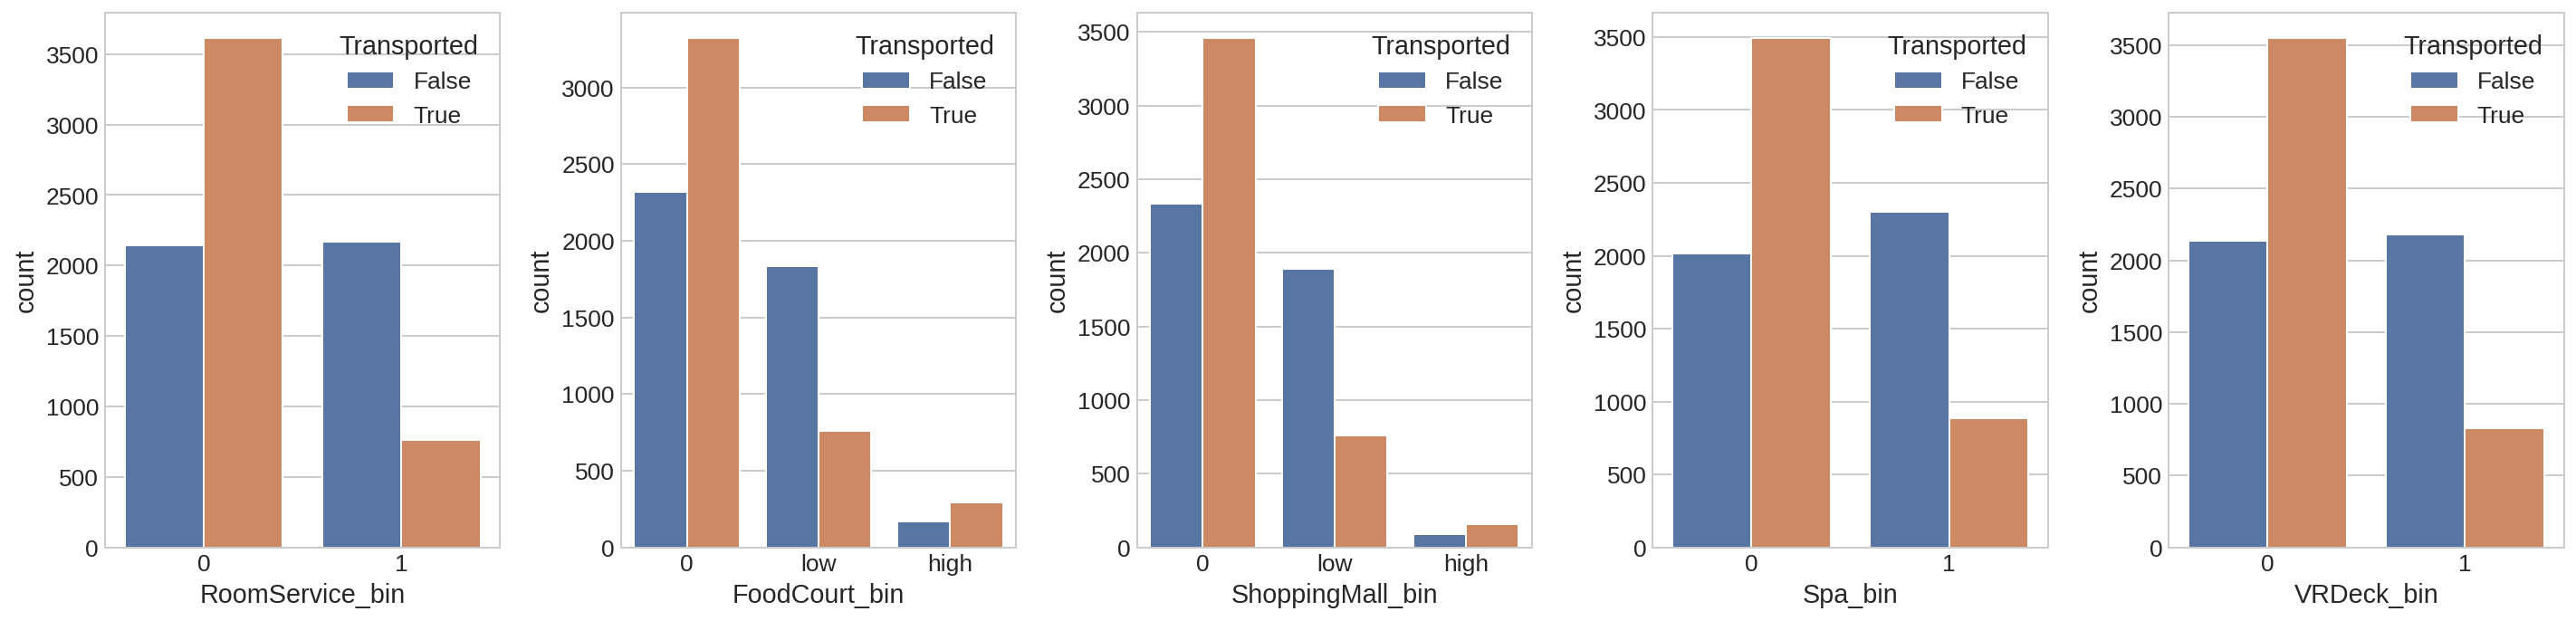

In [418]:
df["RoomService_bin"] = 0
df.loc[ df["RoomService"]>0, "RoomService_bin"] = 1

df["FoodCourt_bin"] = '0'
df.loc[ (df["FoodCourt"]>0) & (df["FoodCourt"]<2500), "FoodCourt_bin"] = "low"
df.loc[ (df["FoodCourt"]>=2500), "FoodCourt_bin"] = "high"

df["ShoppingMall_bin"] = '0'
df.loc[ (df["ShoppingMall"]>0) & (df["ShoppingMall"]<1400), "ShoppingMall_bin"] = "low"
df.loc[ (df["ShoppingMall"]>=1400), "ShoppingMall_bin"] = "high"

df["Spa_bin"] = 0
df.loc[ df["Spa"]>0, "Spa_bin"] = 1

df["VRDeck_bin"] = 0
df.loc[ df["VRDeck"]>0, "VRDeck_bin"] = 1




fig, ax = plt.subplots(1,5, figsize=(20,5))

sns.countplot(data=df, x='RoomService_bin', hue='Transported', ax=ax[0])
# ax[0].set_title("CryoSleep=all")

sns.countplot(data=df, x='FoodCourt_bin', hue='Transported', ax=ax[1])
sns.countplot(data=df, x='ShoppingMall_bin', hue='Transported', ax=ax[2])
sns.countplot(data=df, x='Spa_bin', hue='Transported', ax=ax[3])
sns.countplot(data=df, x='VRDeck_bin', hue='Transported', ax=ax[4])


fig.tight_layout()
plt.show()


#These 5 features will replace the expenditure features

#####Log transform

In [419]:
# 1. By grouping the data I exert control on the input features, but I am not sure this improves the predictions
# 2. The data are very skewed. So, I will log transform them to have a more gaussian-shape. 
# 3. When I test the model, I will try the binned and the log-transformed data seperately and then, I will choose

for cname in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']:
    df[cname + '_' + 'log'] = np.log(1 + df[cname])

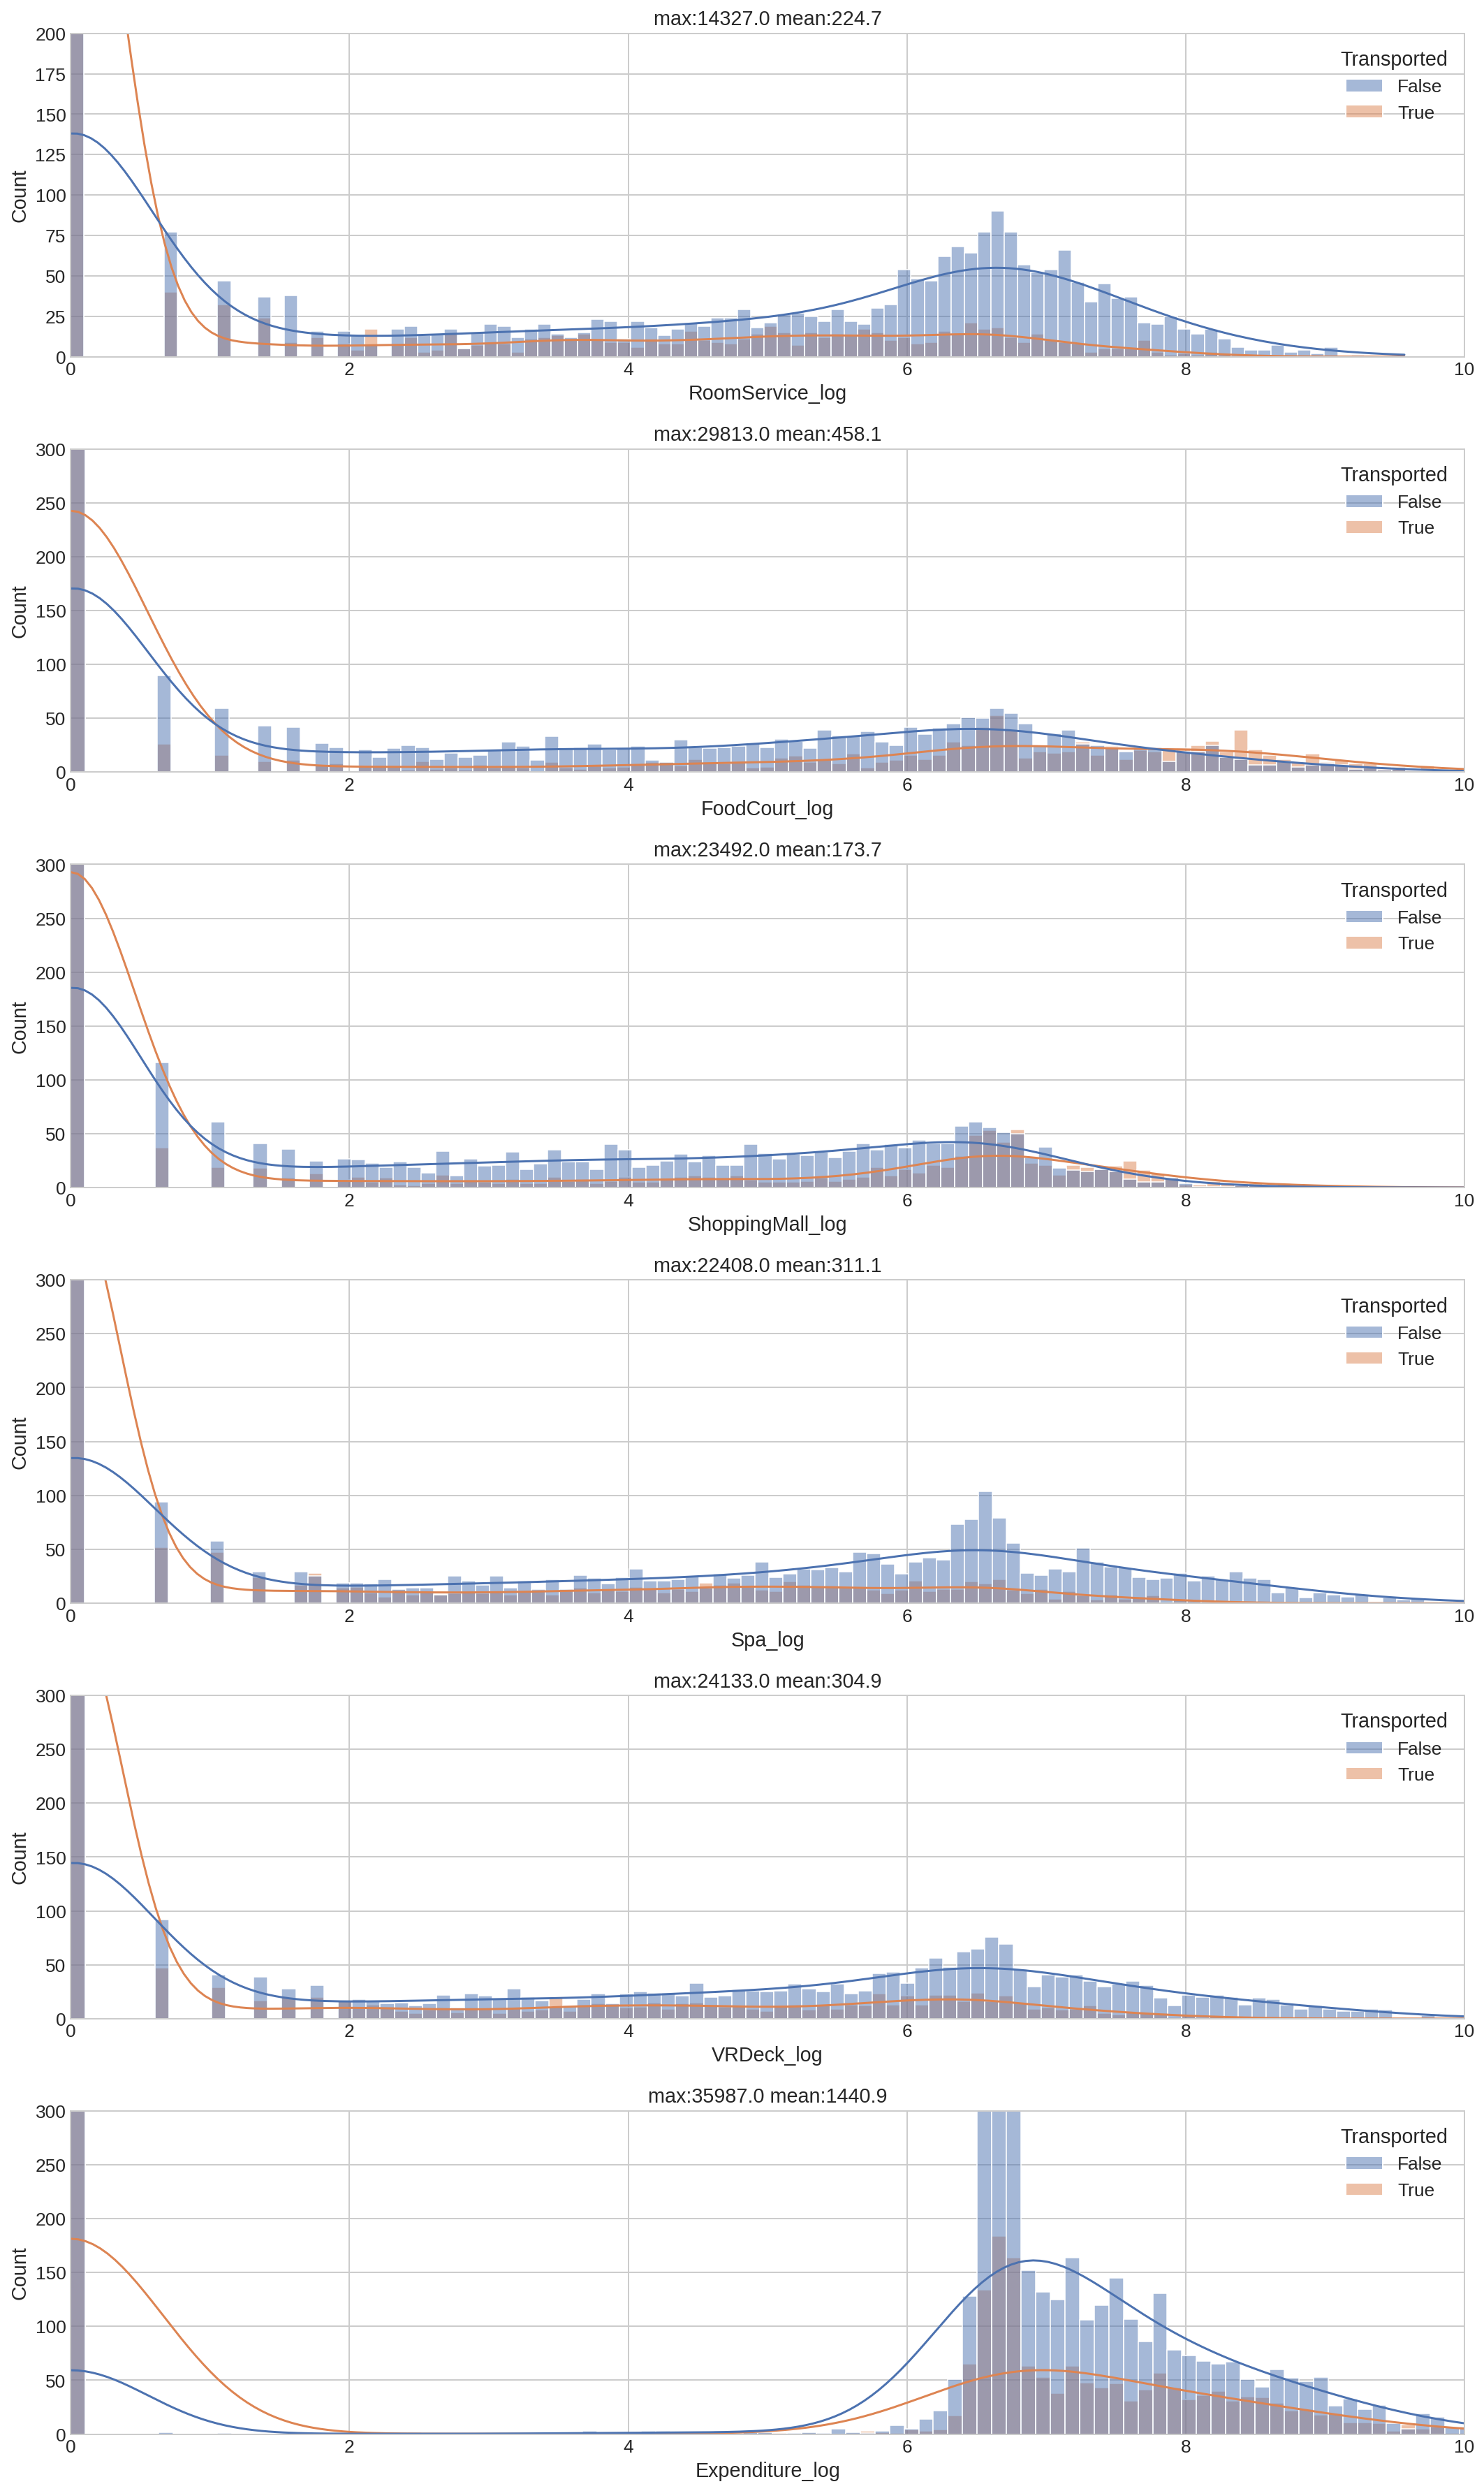

In [420]:
fig,ax = plt.subplots(6,1, figsize=(15,25))
ax = ax.ravel()

# RoomService
sns.histplot(data=df, x="RoomService_log", hue="Transported", bins=100, kde=True, ax=ax[0])
ax[0].set_title("max:{} mean:{:.1f}" .format(df.RoomService.max() , df.RoomService.mean()))
ax[0].set_xlim([0, 10])
ax[0].set_ylim([0, 200])

# FoodCourt
sns.histplot(data=df, x="FoodCourt_log", hue="Transported", bins=100, kde=True, ax=ax[1])
ax[1].set_title("max:{} mean:{:.1f}" .format(df.FoodCourt.max() , df.FoodCourt.mean()))
ax[1].set_xlim([0, 10])
ax[1].set_ylim([0, 300])

# ShoppingMall
sns.histplot(data=df, x="ShoppingMall_log", hue="Transported", bins=100, kde=True, ax=ax[2])
ax[2].set_title("max:{} mean:{:.1f}" .format(df.ShoppingMall.max() , df.ShoppingMall.mean()))
ax[2].set_xlim([0, 10])
ax[2].set_ylim([0, 300])

# Spa
sns.histplot(data=df, x="Spa_log", hue="Transported", bins=100, kde=True, ax=ax[3])
ax[3].set_title("max:{} mean:{:.1f}" .format(df.Spa.max() , df.Spa.mean()))
ax[3].set_xlim([0, 10])
ax[3].set_ylim([0, 300])

# VRDeck
sns.histplot(data=df, x="VRDeck_log", hue="Transported", bins=100, kde=True, ax=ax[4])
ax[4].set_title("max:{} mean:{:.1f}" .format(df.VRDeck.max() , df.VRDeck.mean()))
ax[4].set_xlim([0, 10])
ax[4].set_ylim([0, 300])

# Expenditure
sns.histplot(data=df, x="Expenditure_log", hue="Transported", bins=100, kde=True, ax=ax[5])
ax[5].set_title("max:{} mean:{:.1f}" .format(df.Expenditure.max() , df.Expenditure.mean()))
ax[5].set_xlim([0, 10])
ax[5].set_ylim([0, 300])

fig.tight_layout()
plt.show()

In [421]:
cname="RoomService"
df[cname + "_column"] = 0

###Cabin

8693


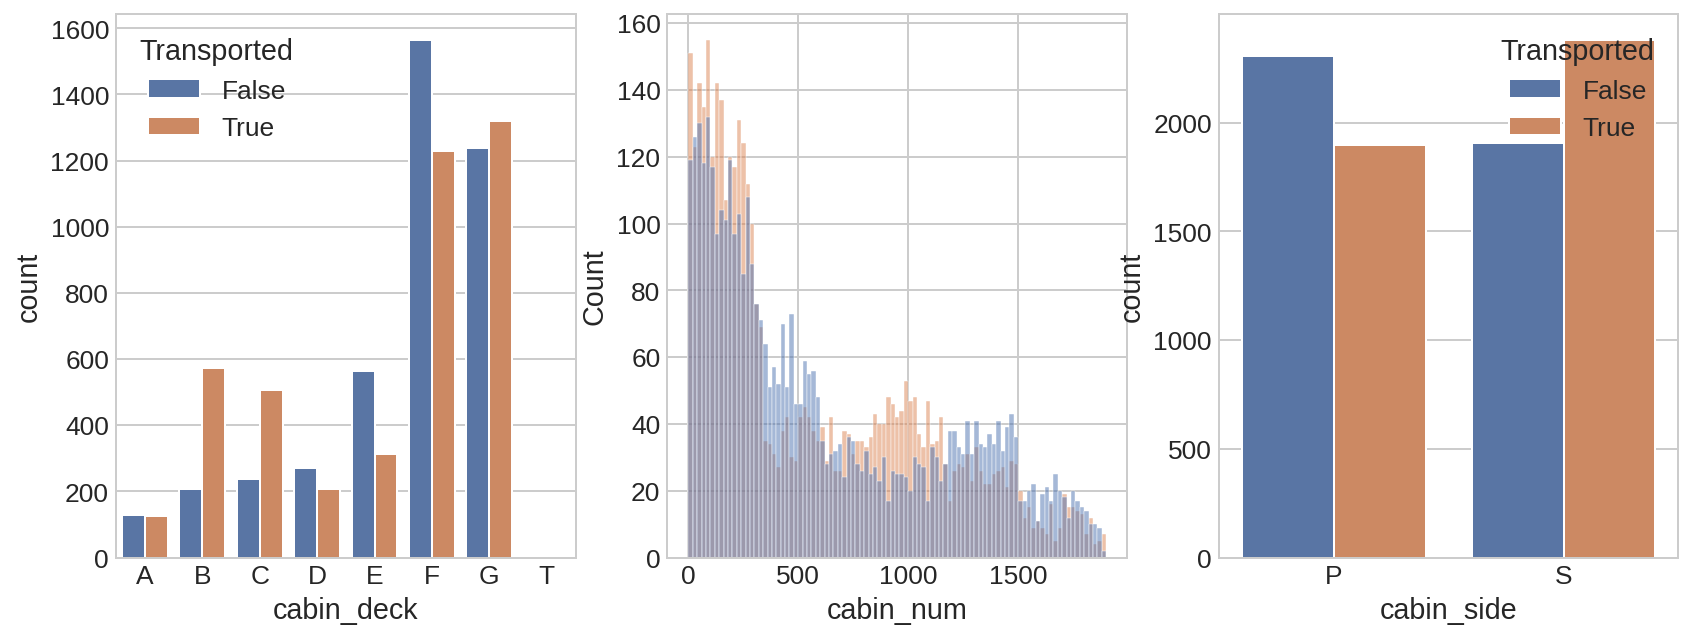

In [422]:
#Split deck, num, side

df["cabin_deck"]= df['Cabin'].str.split("/", expand=True)[0]
df["cabin_num"]= df['Cabin'].str.split("/", expand=True)[1]
df["cabin_side"]= df['Cabin'].str.split("/", expand=True)[2]

df.head()

fig, ax = plt.subplots(1,3, figsize=(14,5))

sns.countplot(data=df, 
              x='cabin_deck', 
              hue="Transported", 
              order= df.cabin_deck.value_counts().sort_index(ascending=True).index, 
              ax=ax[0] 
              )

print(df.shape[0])
df['cabin_num'].fillna('8694', inplace=True)
df['cabin_num'] = df['cabin_num'].astype(int)
df.loc[df['cabin_num'] == 8694 , 'cabin_num'] = np.nan

sns.histplot(data=df, x='cabin_num', hue='Transported',binwidth=20, ax=ax[1])

sns.countplot(data=df, x='cabin_side', hue="Transported", ax=ax[2] )
ax[1].legend(loc= "upper center")

plt.show()

#It is obvious that cabin_deck and cabin_side have predictive values
#What is surprising is the cabin_num. I could break it down in groups

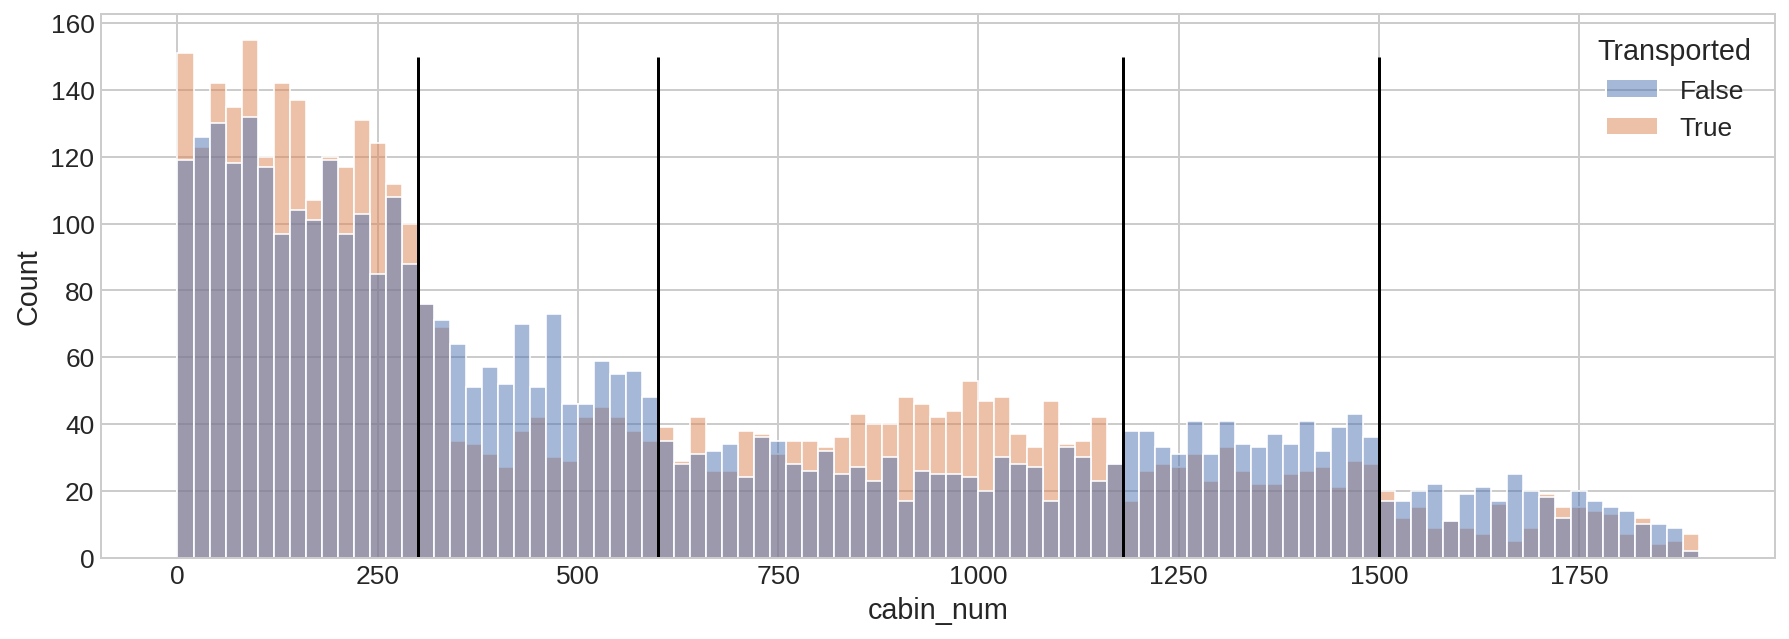

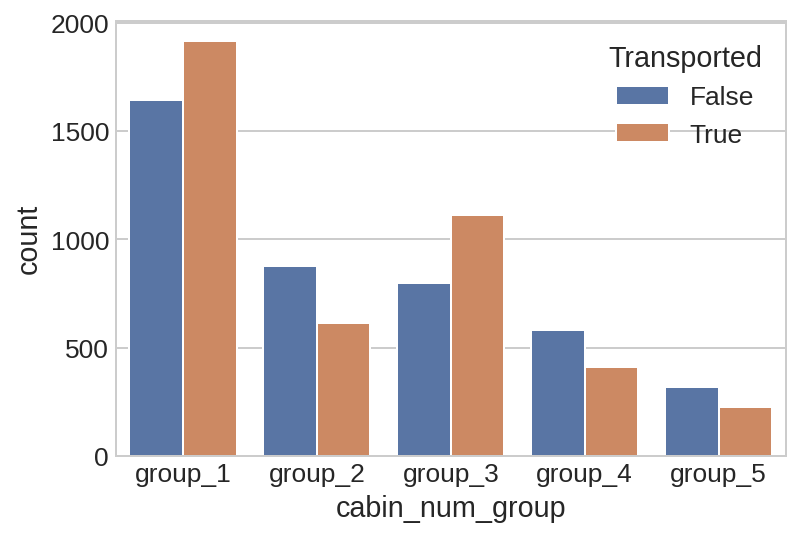

In [423]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
sns.histplot(data=df, x='cabin_num', hue='Transported',binwidth=20)
plt.vlines(300, ymin=0, ymax=150, color='black')
plt.vlines(600, ymin=0, ymax=150, color='black')
plt.vlines(1180, ymin=0, ymax=150, color='black')
plt.vlines(1500, ymin=0, ymax=150, color='black')
plt.show()

#there are clear groups with different transportation rates
#Lets create them

df.loc[df["cabin_num"] <300 , "cabin_num_group"] = "group_1"
df.loc[(df["cabin_num"] >= 300) & (df["cabin_num"] < 600) , "cabin_num_group"] = "group_2"
df.loc[(df["cabin_num"] >= 600) & (df["cabin_num"] < 1180) , "cabin_num_group"] = "group_3"
df.loc[(df["cabin_num"] >= 1180) & (df["cabin_num"] < 1500) , "cabin_num_group"] = "group_4"
df.loc[(df["cabin_num"] >= 1500) & (df["cabin_num"] <= df["cabin_num"].max()) , "cabin_num_group"] = "group_5"

sns.countplot(data=df, x='cabin_num_group', hue="Transported" )

plt.show()

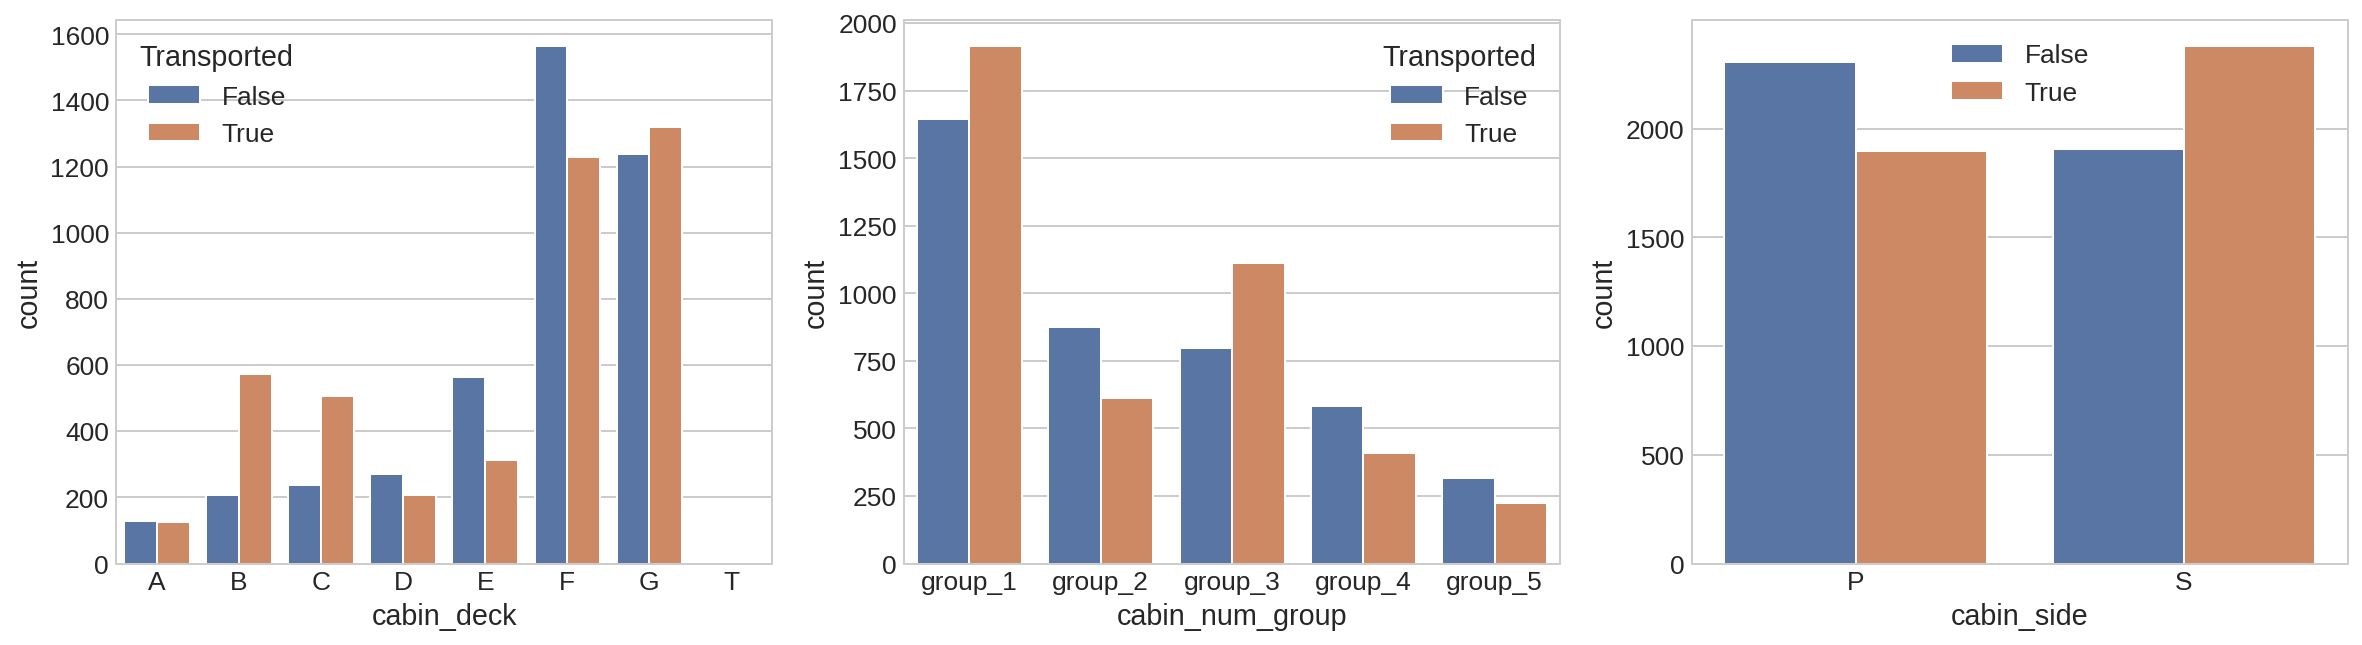

In [424]:
#So, before we move on lets plot again the new features we extracted from cabin
fig, ax = plt.subplots(1,3, figsize=(20,5))

sns.countplot(data=df, 
              x='cabin_deck', 
              hue="Transported", 
              order= df.cabin_deck.value_counts().sort_index(ascending=True).index, 
              ax=ax[0] 
              )


sns.countplot(data=df, x='cabin_num_group', hue='Transported',ax=ax[1])

sns.countplot(data=df, 
              x='cabin_side', 
              hue="Transported", 
              ax=ax[2] 
              )
ax[2].legend(loc= "upper center")

plt.show()


###PassengerID and Name

unique gggg values: 6217
correlation btwn gggg_size and lastname_gggg_size is 0.856


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,cabin_num,cabin_side,cabin_num_group,gggg,gggg_size,pp,lastname,lastname_size,lastname_gggg,lastname_gggg_size
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,P,group_1,0001,1,01,Ofracculy,1.0,Ofracculy_0001,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,0.0,S,group_1,0002,1,01,Vines,4.0,Vines_0002,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,0.0,S,group_1,0003,2,01,Susent,6.0,Susent_0003,2


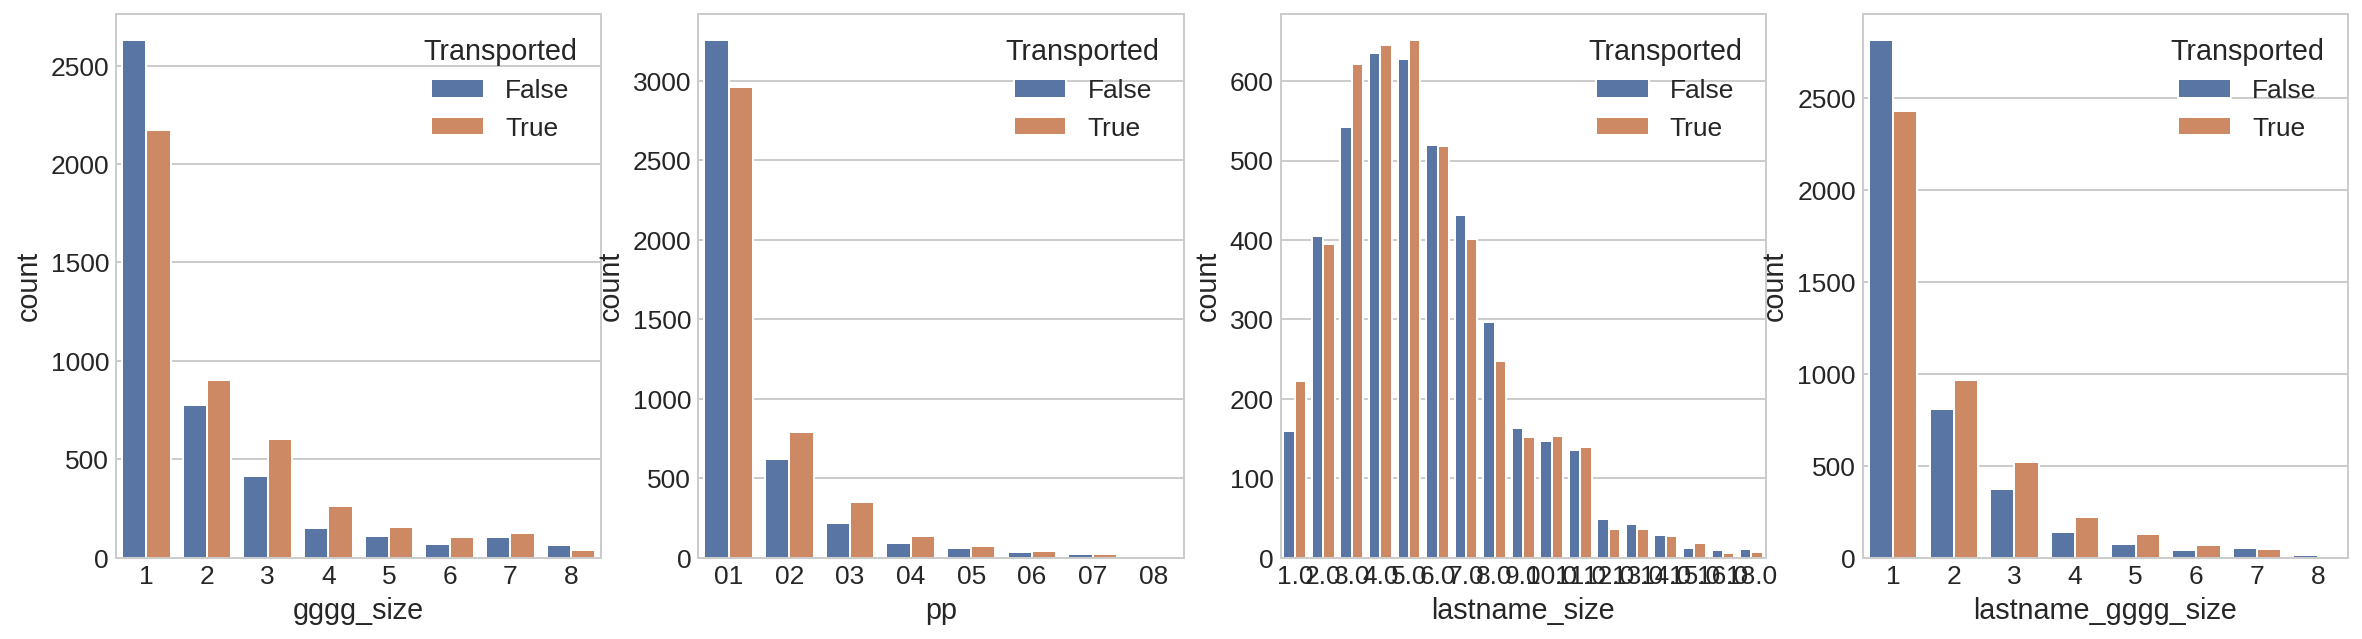

In [425]:
# I kept this one in the end because in the feature description it says that 
# usually families were put in the same group, but there could be group member 
# that don't belong in the same family.
#I speculate that at leat one person from the same group or at least a person 
# from the family was transported

# I will split PassengerID into gggg and pp and rom Name i will extract the last_name
# Then I will merge lastname with gggg to make sure that i picked lastname from one family.
# (You never know, there could be families with the same lastname). Fingers crossed.

df["gggg"]= df['PassengerId'].str.split("_", expand=True)[0]

print("unique gggg values: {}" .format(df["gggg"].unique().shape[0]) )

#Too many unique values for gggg. But I could group them by group size
df["gggg_size"]= df['gggg'].map(df['gggg'].value_counts())
#Now I have 8 value



df["pp"]= df['PassengerId'].str.split("_", expand=True)[1]

fig,ax= plt.subplots(1,4, figsize=(20,5))

sns.countplot(data=df, 
              x='gggg_size', 
              hue="Transported",
              ax=ax[0]
              )

sns.countplot(data=df, 
              x='pp', 
              hue="Transported",
              ax=ax[1]
              )


#Lets work on lastname now
df["lastname"]= df['Name'].str.split(" ", expand=True)[1]
df["lastname_size"]= df['lastname'].map(df['lastname'].value_counts())

sns.countplot(data=df, 
              x='lastname_size', 
              hue="Transported",
              ax=ax[2]
              )


#Create a new feature with lastname and gggg
df["lastname_gggg"] = df['lastname'].astype(str) + "_" + df['gggg']
#Too many unique values for gggg. But I could group them by group size
df["lastname_gggg_size"]= df['lastname_gggg'].map(df['lastname_gggg'].value_counts())

sns.countplot(data=df, 
              x='lastname_gggg_size', 
              hue="Transported",
              ax=ax[3]
              )


print("correlation btwn gggg_size and lastname_gggg_size is {:.3f}" .format(df["gggg_size"].corr(df["lastname_gggg_size"])))

#gggg_size anf lastname_gggg_size are highly correlated. They will produce multi-collinearity.
#Therefore, I will keep one and drop one. I will keep gggg_size.
df.head(3)

In [426]:
#Features to feed the model with
#-----------------------------------
#1  HomePlant: Earth, Europa, Mars
#2  CryoSleep: True, False
#3  Destination: TRAPPIST-1e, PSO J318.5-22, 55 Cancri e
#4  VIP: True, False
#5  Age_group: '28-39', '18-27', '40-80', '0-17'
#6  RoomService_bin
#7  FoodCourt_bin
#8  ShoppingMall_bin
#9  Spa_bin
#10 VRDeck_bin
#11 cabin_deck
#12 cabin_side
#13 cabin_num_group
#14 gggg_size

## Feature Engineering

In [427]:
df_train= train.copy()
df_test= test.copy()

In [428]:
df_train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


####Age_group

In [429]:
def engineering_age(df):
    df.loc[df["Age"] <= 17 , "Age_group"] = "0-17"
    df.loc[(df["Age"] > 17) & (df["Age"] <= 27) , "Age_group"] = "18-27"
    df.loc[(df["Age"] > 27) & (df["Age"] <= 39) , "Age_group"] = "28-39"
    df.loc[(df["Age"] > 39) & (df["Age"] <= df["Age"].max()) , "Age_group"] = "40-80"
    return df

df_train= engineering_age(df_train)
df_test= engineering_age(df_test)


####Expenses

In [430]:
def engineering_expenses(df):
    df["RoomService_bin"] = 'no'
    df.loc[ df["RoomService"]>0, "RoomService_bin"] = 'yes'

    df["FoodCourt_bin"] = "0"
    df.loc[ (df["FoodCourt"]>0) & (df["FoodCourt"]<2500), "FoodCourt_bin"] = "low"
    df.loc[ (df["FoodCourt"]>=2500), "FoodCourt_bin"] = "high"

    df["ShoppingMall_bin"] = "0"
    df.loc[ (df["ShoppingMall"]>0) & (df["ShoppingMall"]<1400), "ShoppingMall_bin"] = "low"
    df.loc[ (df["ShoppingMall"]>=1400), "ShoppingMall_bin"] = "high"

    df["Spa_bin"] = 'no'
    df.loc[ df["Spa"]>0, "Spa_bin"] = 'yes'

    df["VRDeck_bin"] = 'no'
    df.loc[ df["VRDeck"]>0, "VRDeck_bin"] = 'yes'

    df['Expenditure']=df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)

    return(df)



df_train= engineering_expenses(df_train)
df_test= engineering_expenses(df_test)

for cname in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Expenditure']:
    df_train[cname + '_' + 'log'] = np.log(1 + df_train[cname])
    df_test[cname + '_' + 'log'] = np.log(1 + df_test[cname])


####Cabin

In [431]:
def engineering_cabin(df):
    df["cabin_deck"]= df['Cabin'].str.split("/", expand=True)[0]
    df["cabin_side"]= df['Cabin'].str.split("/", expand=True)[2]
    df["cabin_num"]= df['Cabin'].str.split("/", expand=True)[1]

    df['cabin_num'].fillna('999999', inplace=True)
    df['cabin_num'] = df['cabin_num'].astype(int)
    df.loc[df['cabin_num'] == 999999 , 'cabin_num'] = np.nan

    df.loc[df["cabin_num"] <300 , "cabin_num_group"] = "group_1"
    df.loc[(df["cabin_num"] >= 300) & (df["cabin_num"] < 600) , "cabin_num_group"] = "group_2"
    df.loc[(df["cabin_num"] >= 600) & (df["cabin_num"] < 1180) , "cabin_num_group"] = "group_3"
    df.loc[(df["cabin_num"] >= 1180) & (df["cabin_num"] < 1500) , "cabin_num_group"] = "group_4"
    df.loc[(df["cabin_num"] >= 1500) & (df["cabin_num"] <= df["cabin_num"].max()) , "cabin_num_group"] = "group_5"

    return(df)

df_train= engineering_cabin(df_train)
df_test= engineering_cabin(df_test)

####PassengerID and Name

In [432]:
def engineering_passengerId(df):
    df["group"]= df['PassengerId'].str.split("_", expand=True)[0]
    df["group_size"]= df['group'].map(df['group'].value_counts())
    return(df)

df_train= engineering_passengerId(df_train)
df_test= engineering_passengerId(df_test)

In [433]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PassengerId       4277 non-null   object 
 1   HomePlanet        4190 non-null   object 
 2   CryoSleep         4184 non-null   object 
 3   Cabin             4177 non-null   object 
 4   Destination       4185 non-null   object 
 5   Age               4186 non-null   float64
 6   VIP               4184 non-null   object 
 7   RoomService       4195 non-null   float64
 8   FoodCourt         4171 non-null   float64
 9   ShoppingMall      4179 non-null   float64
 10  Spa               4176 non-null   float64
 11  VRDeck            4197 non-null   float64
 12  Name              4183 non-null   object 
 13  Age_group         4186 non-null   object 
 14  RoomService_bin   4277 non-null   object 
 15  FoodCourt_bin     4277 non-null   object 
 16  ShoppingMall_bin  4277 non-null   object 


#Feature Selection

In [434]:
cols_keep=["HomePlanet",
           "CryoSleep",
           "Destination",
           "VIP",
           "Age",
           "RoomService_log",
           "FoodCourt_log",
           "ShoppingMall_log",
           "Spa_log",
           "VRDeck_log",
           "Expenditure_log",
           "cabin_deck",
           "cabin_side",
           "cabin_num_group",
           "group_size"]

In [435]:
X= df_train[cols_keep]

y=df_train["Transported"]

X_test=df_test[cols_keep]

In [436]:
# Indentify numerical and categorical columns
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

print("numerical cols: {}\n" .format(numerical_cols))
print("categorical cols: {}\n" .format(categorical_cols))

numerical cols: ['Age', 'RoomService_log', 'FoodCourt_log', 'ShoppingMall_log', 'Spa_log', 'VRDeck_log', 'Expenditure_log', 'group_size']

categorical cols: ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'cabin_deck', 'cabin_side', 'cabin_num_group']



In [437]:
# X["RoomService_bin"]= X["RoomService_bin"].astype("str")
# X["Spa_bin"]= X["Spa_bin"].astype("str")
# X["VRDeck_bin"]= X["VRDeck_bin"].astype("str")
# X["gggg_size"]= X["gggg_size"].astype("str")
# X.info() 

In [438]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA


numerical_transformer = Pipeline([
    ('numerical_imputer', SimpleImputer(strategy='median')),
    ('scaler_numerical', StandardScaler()),
]) 

categorical_transformer = Pipeline([
    ('categorical_imputer', SimpleImputer(strategy='most_frequent')),
    ('categorical_ohe', OneHotEncoder(sparse=False, handle_unknown='ignore')),
    ('scaler_categorical', StandardScaler())
])

In [439]:
# X.ShoppingMall_bin= X.ShoppingMall_bin.astype(str)
# X.FoodCourt_bin= X.FoodCourt_bin.astype(str)

In [440]:
# cat_cols=["HomePlanet", 
#       "Destination", 
#       "CryoSleep", 
#       "VIP", 
#       "RoomService_bin",
#       "Spa_bin",
#       "VRDeck_bin",
#       "cabin_deck",
#       "cabin_side",
#       "cabin_num_group",
#       "gggg_size",
#       "ShoppingMall_bin",
#       "FoodCourt_bin",
#       ]

# num_cols=["Age"]
# # "FoodCourt_bin"
# #"ShoppingMall_bin"

In [441]:
from sklearn.compose import ColumnTransformer

# Combine preprocessing
ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
        remainder='passthrough')

# ct = ColumnTransformer(transformers=[('cat', categorical_transformer, cols)], remainder='passthrough')

# Apply preprocessing
# X = ct.fit_transform(X)
# X_test = ct.transform(X_test)

In [442]:
# from sklearn.ensemble import GradientBoostingClassifier
# model= GradientBoostingClassifier()

# pipe = Pipeline([
#     ('ct', ct),
#     ('model', model)
#     ])

In [443]:
# from sklearn.model_selection import KFold
# folds = KFold(n_splits = 3, shuffle = True, random_state = 100)

In [444]:
# cross_val_score(pipe, X, y, cv=folds, scoring="accuracy").mean()
#Age_group + Age: 0.7665
#Age: 0.7683

In [445]:
S%%%

SyntaxError: ignored

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# param_dist = {'model__n_estimators': [5,10,20,50,100, 150,200,250,300,350,400],
#               'model__learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
#               'model__max_depth':[3,5,10],
#               'model__max_features':["log2","sqrt"]}




# random_search = RandomizedSearchCV(pipe,
#                                    param_distributions=param_dist,
#                                    n_iter=100,cv=folds
#                                    )

# random_search.fit(X_train, y_train)
# print("best_score: {}".format(random_search.best_score_))
# print(random_search.best_params_)

# # best_score: 0.7966197108580348
# # {'model__n_estimators': 100, 'model__max_features': 'sqrt', 'model__max_depth': 10, 'model__learning_rate': 0.01}
# # submission: 0.79

#Select model

In [446]:
# Train-validation split
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      stratify= y,
                                                      train_size=0.8,
                                                      test_size=0.2,
                                                      random_state= 0)

In [447]:
#classification models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn import svm

#Design pipelines

pipe_lr = Pipeline([
    ('ct', ct),
    ('LR', LogisticRegression(random_state=42))
    ])


pipe_dt = Pipeline([
    ('ct', ct),
    ('DT',DecisionTreeClassifier(random_state=42))
    ])


pipe_rf = Pipeline([
    ('ct', ct),
    ('RF',RandomForestClassifier(random_state=42))
    ])


pipe_knn = Pipeline([
    ('ct', ct),
    ('KNN', KNeighborsClassifier())])


pipe_svm = Pipeline([
    ('ct', ct),
    ('SVM', svm.SVC(random_state=42))
    ])


pipe_xgb = Pipeline([
    ('ct', ct),
    ('XGB', XGBClassifier(random_state=42))
    ])

In [448]:
#tune parameters

param_range = [1, 2, 3, 4, 5, 6]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [50,100,150]
learning_rates = [.1,.2,.3]

lr_param_grid = [{'LR__penalty': ['l1', 'l2'],
                   'LR__C': param_range_fl,
                   'LR__solver': ['liblinear']}]

dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
                   'DT__min_samples_leaf': param_range,
                   'DT__max_depth': param_range,
                   'DT__min_samples_split': param_range[1:]}]

rf_param_grid = [{'RF__min_samples_leaf': param_range,
                   'RF__max_depth': param_range,
                   'RF__min_samples_split': param_range[1:]}]

knn_param_grid = [{'KNN__n_neighbors': param_range,
                   'KNN__weights': ['uniform', 'distance'],
                   'KNN__metric': ['euclidean', 'manhattan']}]

svm_param_grid = [{'SVM__kernel': ['linear', 'rbf'], 
                    'SVM__C': param_range}]

xgb_param_grid = [{'XGB__learning_rate': learning_rates,
                    'XGB__max_depth': param_range,
                    'XGB__min_child_weight': param_range[:2],
                    'XGB__subsample': param_range_fl,
                    'XGB__n_estimators': n_estimators}]

In [449]:
from sklearn.model_selection import GridSearchCV

#Instantiate GridsearchCV

lr_grid_search = GridSearchCV(estimator=pipe_lr,
        param_grid=lr_param_grid,
        scoring='accuracy',
        cv=None)

dt_grid_search = GridSearchCV(estimator=pipe_dt,
        param_grid=dt_param_grid,
        scoring='accuracy',
        cv=None)

rf_grid_search = GridSearchCV(estimator=pipe_rf,
        param_grid=rf_param_grid,
        scoring='accuracy',
        cv=None)

knn_grid_search = GridSearchCV(estimator=pipe_knn,
        param_grid=knn_param_grid,
        scoring='accuracy',
        cv=None)

svm_grid_search = GridSearchCV(estimator=pipe_svm,
        param_grid=svm_param_grid,
        scoring='accuracy',
        cv=None)

xgb_grid_search = GridSearchCV(estimator=pipe_xgb,
        param_grid=xgb_param_grid,
        scoring='accuracy',
        cv=None)

In [450]:
#fit the models
grids = [lr_grid_search, dt_grid_search, rf_grid_search, knn_grid_search, svm_grid_search, xgb_grid_search]

for pipe in grids:
    print("model fitting in process {}: \n" .format(pipe))
    pipe.fit(X_train, y_train)

In [451]:
grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees', 
             2: 'Random Forest', 3: 'K-Nearest Neighbors', 
             4: 'Support Vector Machines', 5: 'XGBoost'}
             
for i, model in enumerate(grids):
    print('{} Test Accuracy: {}'.format(grid_dict[i], model.score(X_valid,y_valid)))
    print('{} Best Params: {}'.format(grid_dict[i], model.best_params_))

Logistic Regression Test Accuracy: 0.7705577918343876
Logistic Regression Best Params: {'LR__C': 0.1, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}
Decision Trees Test Accuracy: 0.7602070155261644
Decision Trees Best Params: {'DT__criterion': 'entropy', 'DT__max_depth': 6, 'DT__min_samples_leaf': 4, 'DT__min_samples_split': 2}
Random Forest Test Accuracy: 0.7711328349626222
Random Forest Best Params: {'RF__max_depth': 6, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 3}
K-Nearest Neighbors Test Accuracy: 0.7429557216791259
K-Nearest Neighbors Best Params: {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 5, 'KNN__weights': 'uniform'}
Support Vector Machines Test Accuracy: 0.7958596894767107
Support Vector Machines Best Params: {'SVM__C': 2, 'SVM__kernel': 'rbf'}
XGBoost Test Accuracy: 0.8050603795284647
XGBoost Best Params: {'XGB__learning_rate': 0.1, 'XGB__max_depth': 4, 'XGB__min_child_weight': 1, 'XGB__n_estimators': 100, 'XGB__subsample': 1.0}


In [499]:
grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees', 
             2: 'Random Forest', 3: 'K-Nearest Neighbors', 
             4: 'Support Vector Machines', 5: 'XGBoost'}


model_name= []
model_score= []
model_best_params= []
for i, model in enumerate(grids):

    model_name.append(model.estimator.steps[-1][0])
    model_score.append( model.score(X_valid,y_valid) )
    model_best_params.append( model.best_params_ )

d = {'name': model_name, 'score': np.round(model_score, 4), 'best_params': model_best_params}
model_results= pd.DataFrame(data=d)

In [500]:
model_score

[0.7705577918343876,
 0.7602070155261644,
 0.7711328349626222,
 0.7429557216791259,
 0.7958596894767107,
 0.8050603795284647]

In [505]:
#best model index
best_model_index= model_results.score.argmax()

In [506]:
#print out the best parameters of the best model
model_best_params[best_model_index]

{'XGB__learning_rate': 0.1,
 'XGB__max_depth': 4,
 'XGB__min_child_weight': 1,
 'XGB__n_estimators': 100,
 'XGB__subsample': 1.0}

In [ ]:
# grids = [lr_grid_search, dt_grid_search, rf_grid_search, knn_grid_search, svm_grid_search, xgb_grid_search]

# for pipe in grids[best_model_index]:
#     print("model fitting in process {}: \n" .format(pipe))
#     pipe.fit(X, y)

In [509]:
pipe = Pipeline([
    ('ct', ct),
    ('XGB', XGBClassifier(**model_best_params[best_model_index], random_state=42))
    ])

pipe.fit(X, y)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('numerical_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler_numerical',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService_log',
                                                   'FoodCourt_log',
                                                   'ShoppingMall_log',
                                                   'Spa_log', 'VRDeck_log',
                                                   'Expenditure_log',
                                                   'group_size']),
                                                 ('cat',
         

In [510]:
y_pred = pipe.predict(X_test)

In [511]:
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/space_titanic_kaggle/test.csv')
test["Transported"]= y_pred

In [512]:
result = test[["PassengerId", "Transported"]]
result

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [514]:
from google.colab import files

result.to_csv('submission.csv' , index=False)
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>